In this notebook I explore the Linear regression model for the April 2019 preprocessed bike data and try to improve the model through adding polynomial and lag features

In [56]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import joblib

In [3]:
month = "04"
path  = f"../data/od-trips-2019/2019-{month}.csv"
april_2019_OD = pd.read_csv(path)

In [4]:
df = april_2019_OD.copy()
df['Departure'] = pd.to_datetime(df['Departure'], errors='coerce', format='mixed')
df['Return'] = pd.to_datetime(df['Return'], errors='coerce', format='mixed')

df['dep_hour'] = df['Departure'].dt.floor('h')
df['ret_hour'] = df['Return'].dt.floor('h')

# --- Hourly DEPARTURES per station ---
departures = (
    df.groupby(['Departure station id', 'dep_hour'])
      .size()
      .reset_index(name='departures')
      .rename(columns={'Departure station id': 'station_id', 'dep_hour': 'hour'})
)
# --- Hourly ARRIVALS per station ---
arrivals = (
    df.groupby(['Return station id', 'ret_hour'])
      .size()
      .reset_index(name='arrivals')
      .rename(columns={'Return station id': 'station_id', 'ret_hour': 'hour'})
)
# --- Merge them together (outer join to include hours with only dep/arr) ---
station_hourly = pd.merge(departures, arrivals,on=['station_id', 'hour'], how='outer').fillna(0)

# Get full range of hours and all station IDs
hours = pd.date_range(df['Departure'].min().floor('h'),
                      df['Return'].max().ceil('h'),
                      freq='H')
stations = df['Departure station id'].unique()
# Create full index
multi_index = pd.MultiIndex.from_product([stations, hours], names=['station_id', 'hour'])
full = pd.DataFrame(index=multi_index).reset_index()
# Merge with your counts and fill missing values with 0
station_hourly_full = pd.merge(full, station_hourly,on=['station_id', 'hour'], how='left').fillna(0)

station_hourly_full['weekday'] = station_hourly_full['hour'].dt.dayofweek
station_hourly_full['month']   = station_hourly_full['hour'].dt.month
station_hourly_full['hour_of_day'] = station_hourly_full['hour'].dt.hour

cap_df = pd.read_csv("../data/Helsingin_ja_Espoon_kaupunkipyöräasemat_avoin_7704606743268189464.csv")
cap_df = cap_df[['ID', 'Kapasiteet']]
cap_df.rename(columns={'ID': 'station_id', 'Kapasiteet': 'capacity'}, inplace=True)

stations_binary = station_hourly.copy()
stations_binary = stations_binary.merge(cap_df, on="station_id", how="left")
stations_binary.dropna(subset=['capacity'], inplace=True)

# Ensure datetime format
stations_binary['hour'] = pd.to_datetime(stations_binary['hour'])
# Create full hourly timeline for all stations
full_range = pd.date_range(stations_binary['hour'].min(), stations_binary['hour'].max(), freq='H')
stations = stations_binary['station_id'].unique()
# Cartesian product: all (station, hour) pairs
full_index = pd.MultiIndex.from_product([stations, full_range], names=['station_id', 'hour'])
stations_binary_full = (
    stations_binary.set_index(['station_id', 'hour'])
      .reindex(full_index)
      .reset_index())
# Fill missing values
stations_binary_full['departures'] = stations_binary_full['departures'].fillna(0)
stations_binary_full['arrivals'] = stations_binary_full['arrivals'].fillna(0)
stations_binary_full['capacity'] = stations_binary_full.groupby('station_id')['capacity'].transform(lambda x: x.ffill().bfill())
# Compute net flow
stations_binary_full['net_flow'] = stations_binary_full['arrivals'] - stations_binary_full['departures']
# Compute cumulative available bikes per station
def compute_availability(g):
    start_val = g['capacity'].iloc[0] / 2  # assume half capacity at start
    available = start_val + g['net_flow'].cumsum()
    available = np.clip(available, 0, g['capacity'].iloc[0])  # keep within [0, capacity]
    g['available_bikes'] = available
    return g
stations_binary_full = stations_binary_full.groupby('station_id', group_keys=False).apply(compute_availability)
# Add binary column “empty”
stations_binary_full['empty'] = (stations_binary_full['available_bikes'] <= 0).astype(int)
# Add time-based covariates
stations_binary_full['hour_of_day'] = stations_binary_full['hour'].dt.hour
stations_binary_full['day_of_week'] = stations_binary_full['hour'].dt.dayofweek  # Monday = 0
stations_binary_full['month'] = stations_binary_full['hour'].dt.month
stations_binary_full['is_weekend'] = stations_binary_full['day_of_week'].isin([5, 6]).astype(int)

df_full = stations_binary_full.copy()


/tmp/ipykernel_1352446/1826326903.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(df['Departure'].min().floor('h'),
/tmp/ipykernel_1352446/1826326903.py:51: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(stations_binary['hour'].min(), stations_binary['hour'].max(), freq='H')
/tmp/ipykernel_1352446/1826326903.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stations_binary_full = stations_binary_full.groupby('station_id', group_keys=False).apply(compute_availability)


In [8]:
df_full

station_id                hour  departures  arrivals  capacity  \
0              1.0 2019-04-01 05:00:00         0.0       0.0      30.0   
1              1.0 2019-04-01 06:00:00         0.0       0.0      30.0   
2              1.0 2019-04-01 07:00:00         0.0       0.0      30.0   
3              1.0 2019-04-01 08:00:00         0.0       2.0      30.0   
4              1.0 2019-04-01 09:00:00         0.0       0.0      30.0   
...            ...                 ...         ...       ...       ...   
415397       769.0 2019-05-22 05:00:00         0.0       0.0      12.0   
415398       769.0 2019-05-22 06:00:00         0.0       0.0      12.0   
415399       769.0 2019-05-22 07:00:00         0.0       0.0      12.0   
415400       769.0 2019-05-22 08:00:00         0.0       0.0      12.0   
415401       769.0 2019-05-22 09:00:00         0.0       0.0      12.0   

        net_flow  available_bikes  empty  hour_of_day  day_of_week  month  \
0            0.0             15.0      0            5            0      4   
1            0.0             15.0      0            6            0      4   
2            0.0             15.0      0            7            0      4   
3            2.0             17.0      0            8            0      4   
4            0.0             17.0      0            9            0      4   
...          ...              ...    ...          ...          ...    ...   
415397       0.0              0.0      1            5            2      5   
415398       0.0              0.0      1            6            2      5   
415399       0.0              0.0      1            7            2      5   
415400       0.0              0.0      1            8            2      5   
415401       0.0              0.0      1            9            2      5   

        is_weekend  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
415397           0  
415398           0  
415399           0  
415400           0  
415401           0  

[415402 rows x 12 columns]

## Linear regression model (not binary classifier)

***

In [15]:
df_lag = df_full.copy()
df_lag['hour'] = pd.to_datetime(df_lag['hour'])
# Sort for lag features
df_lag = df_lag.sort_values(['station_id', 'hour'])
# --- ADD LAG FEATURES ---
df_lag['prev_available'] = df_lag.groupby('station_id')['available_bikes'].shift(1)
df_lag['prev_departures'] = df_lag.groupby('station_id')['departures'].shift(1)
df_lag['prev_arrivals'] = df_lag.groupby('station_id')['arrivals'].shift(1)
# Drop first hour for each station (NaNs)
df_lag = df_lag.dropna(subset=['prev_available', 'prev_departures', 'prev_arrivals'])
# --- FEATURE ENGINEERING ---
df_lag['hour_of_day'] = df_lag['hour'].dt.hour
df_lag['day_of_week'] = df_lag['hour'].dt.dayofweek
df_lag['month'] = df_lag['hour'].dt.month
df_lag['is_weekend'] = (df_lag['day_of_week'] >= 5).astype(int)



features = ['station_id', 'hour_of_day', 'day_of_week', 'month', 'is_weekend',
            'departures', 'arrivals', 'capacity',
            'prev_available', 'prev_departures', 'prev_arrivals']
target = 'available_bikes'

X = df_lag[features]
y = df_lag[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
X_test

station_id  hour_of_day  day_of_week  month  is_weekend  departures  \
322728       559.0           15            2      5           0         0.0   
286707       505.0           19            0      4           0         2.0   
30782         27.0           14            2      4           0         3.0   
333716       581.0           14            6      4           1         5.0   
67145         56.0           16            4      5           0         0.0   
...            ...          ...          ...    ...         ...         ...   
54543         46.0           16            5      4           1         5.0   
104106        86.0           11            1      5           0         0.0   
169344       143.0           16            5      5           1         0.0   
21805         19.0            5            3      5           0         0.0   
15633         14.0            2            2      5           0         0.0   

        arrivals  capacity  prev_available  prev_departures  prev_arrivals  
322728       0.0      25.0             0.0              0.0            0.0  
286707       2.0      16.0             0.0              3.0            1.0  
30782        2.0      14.0            10.0              3.0            4.0  
333716      10.0      35.0            35.0              5.0            3.0  
67145        0.0      12.0            12.0              0.0            0.0  
...          ...       ...             ...              ...            ...  
54543        2.0      16.0             0.0              9.0            3.0  
104106       0.0      24.0             0.0              0.0            0.0  
169344       0.0      12.0             8.0              0.0            0.0  
21805        0.0      20.0             0.0              0.0            0.0  
15633        0.0      22.0            22.0              0.0            0.0  

[83013 rows x 11 columns]

In [17]:
import joblib
model = joblib.load("/home/rishika/Intro_to_DS/MiniProject/poly_lag_linreg_model_042019.pkl")
# You can now use it to make predictions
y_pred = model.predict(X_test)

In [19]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

Root Mean Squared Error (RMSE): 0.56
R² Score: 0.996


***

In [ ]:

# Features and target
features = ['hour_of_day', 'day_of_week', 'month', 'is_weekend', 'station_id']
target = 'available_bikes'
    
X = df_full[features]
y = df_full[target]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Preprocessing ---
# Numeric features
numeric_features = ['hour_of_day', 'day_of_week', 'month', 'is_weekend']

# Categorical features (station_id → one-hot encoding)
categorical_features = ['station_id']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# --- Linear Regression Model ---
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# --- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model trained!")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")


Model trained!
Root Mean Squared Error (RMSE): 4.20
R² Score: 0.771


In [56]:
joblib.dump(model, "basic_linreg_model_042019.pkl")
print("Model saved successfully!")

Model saved successfully!


Positive coefficient: Increases the expected number of available bikes.

Negative coefficient: Decreases it (i.e., likely busier times or stations).

Large magnitude: Stronger influence on predictions.

and

For hour_of_day or day_of_week, this shows temporal trends.

For station one-hot features (cat__station_id_*), these represent baseline differences across stations.

In [11]:
# Extract coefficients after fitting
regressor = model.named_steps['regressor']
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

coeffs = pd.DataFrame({
    'feature': feature_names,
    'coefficient': regressor.coef_
}).sort_values(by='coefficient', ascending=False)

print(coeffs.head(10))


                   feature  coefficient
67    cat__station_id_65.0    28.828872
43    cat__station_id_41.0    24.646701
14    cat__station_id_12.0    24.035246
149  cat__station_id_161.0    23.577180
275  cat__station_id_581.0    21.632254
296  cat__station_id_625.0    21.041193
270  cat__station_id_571.0    20.385697
135  cat__station_id_137.0    20.326236
4      cat__station_id_1.0    20.289902
125  cat__station_id_127.0    20.023405


In [8]:
feature_names

array(['num__hour_of_day', 'num__day_of_week', 'num__month',
       'num__is_weekend', 'cat__station_id_1.0', 'cat__station_id_2.0',
       'cat__station_id_3.0', 'cat__station_id_4.0',
       'cat__station_id_5.0', 'cat__station_id_6.0',
       'cat__station_id_7.0', 'cat__station_id_8.0',
       'cat__station_id_10.0', 'cat__station_id_11.0',
       'cat__station_id_12.0', 'cat__station_id_13.0',
       'cat__station_id_14.0', 'cat__station_id_15.0',
       'cat__station_id_16.0', 'cat__station_id_17.0',
       'cat__station_id_18.0', 'cat__station_id_19.0',
       'cat__station_id_20.0', 'cat__station_id_21.0',
       'cat__station_id_22.0', 'cat__station_id_23.0',
       'cat__station_id_24.0', 'cat__station_id_25.0',
       'cat__station_id_26.0', 'cat__station_id_27.0',
       'cat__station_id_28.0', 'cat__station_id_29.0',
       'cat__station_id_30.0', 'cat__station_id_31.0',
       'cat__station_id_32.0', 'cat__station_id_33.0',
       'cat__station_id_34.0', 'cat__station_id_

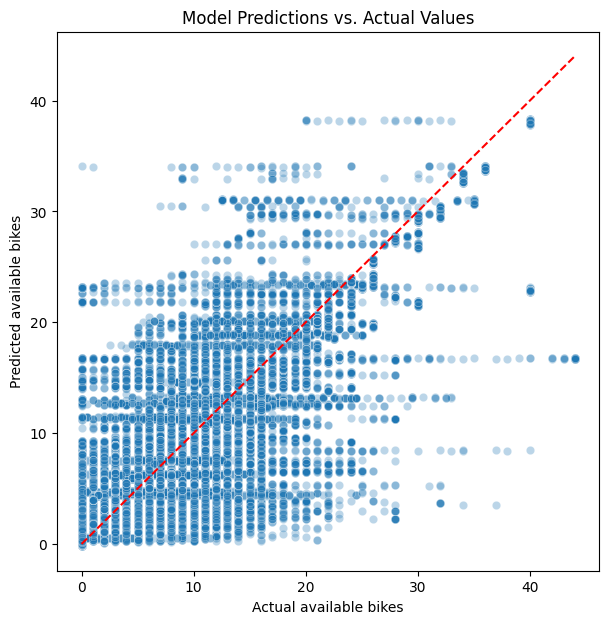

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual available bikes")
plt.ylabel("Predicted available bikes")
plt.title("Model Predictions vs. Actual Values")
plt.show()

Our linear regression predictor is not that great here (r² = 0.77)

## Plotting residuals

Residuals = actual − predicted

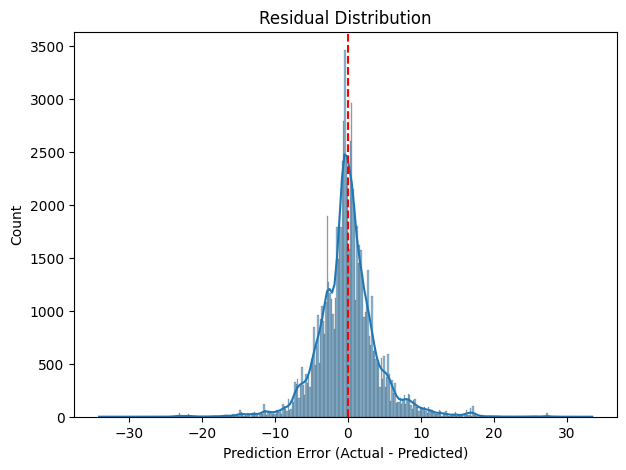

In [13]:
residuals = y_test - y_pred

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True)
plt.axvline(0, color='r', linestyle='--')
plt.title("Residual Distribution")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.show()

In [24]:
residuals.max(), residuals.min()

(np.float64(33.47869774647437), np.float64(-34.07568258692977))

Yikes, good models have residuals roughly centered around zero with no obvious pattern. Centered near 0 → unbiased predictions. Wide or skewed → under/overestimation patterns or missing features.

## Plotting the hourly and daily trend of predicted vs actual

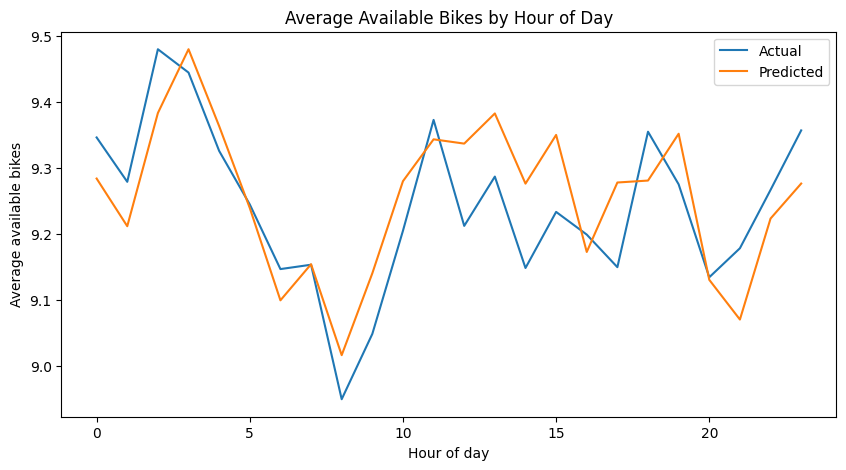

In [14]:
# Add predictions back to test set
X_test_copy = X_test.copy()
X_test_copy['y_true'] = y_test
X_test_copy['y_pred'] = y_pred

# Plot average availability by hour
hourly_avg = X_test_copy.groupby('hour_of_day')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=hourly_avg, x='hour_of_day', y='y_true', label='Actual')
sns.lineplot(data=hourly_avg, x='hour_of_day', y='y_pred', label='Predicted')
plt.title("Average Available Bikes by Hour of Day")
plt.ylabel("Average available bikes")
plt.xlabel("Hour of day")
plt.legend()
plt.show()


Pretty good, our model follow the general trend with some (not too significant) deviations'

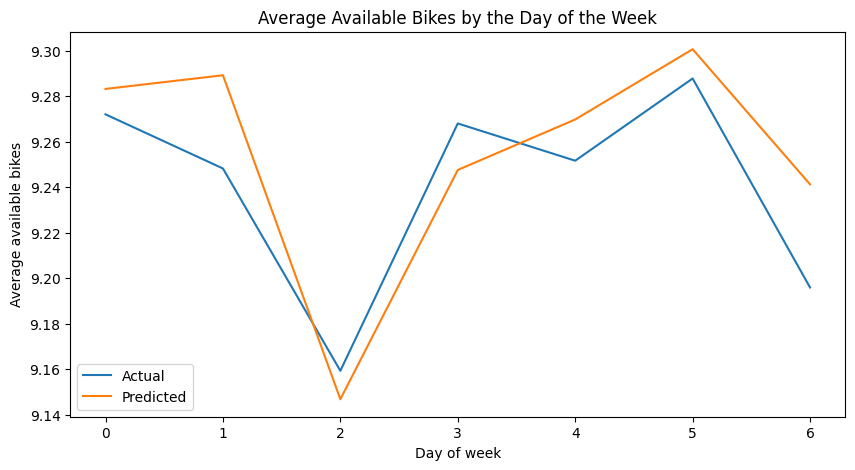

In [19]:
# Add predictions back to test set
X_test_copy = X_test.copy()
X_test_copy['y_true'] = y_test
X_test_copy['y_pred'] = y_pred

# Plot average availability by hour
daily_avg = X_test_copy.groupby('day_of_week')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=daily_avg, x='day_of_week', y='y_true', label='Actual')
sns.lineplot(data=daily_avg, x='day_of_week', y='y_pred', label='Predicted')
plt.title("Average Available Bikes by the Day of the Week")
plt.ylabel("Average available bikes")
plt.xlabel("Day of week")
plt.legend()
plt.show()

Not too bad

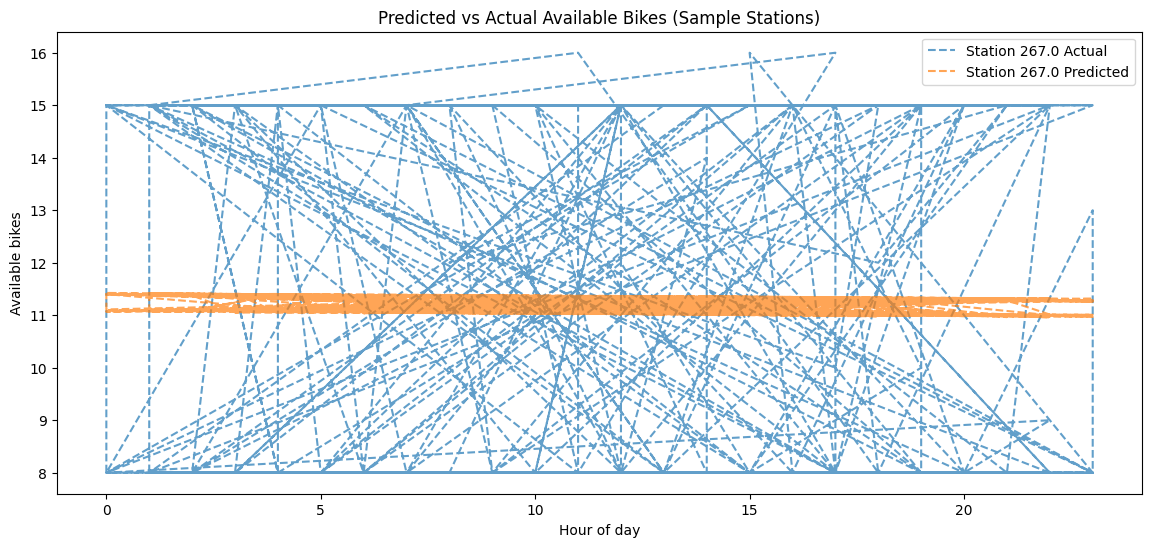

In [32]:
sample_stations = np.random.choice(X_test['station_id'].unique(), size=1, replace=False)

plt.figure(figsize=(14,6))
for station in sample_stations:
    station_data = X_test_copy[X_test_copy['station_id'] == station]
    plt.plot(station_data['hour_of_day'], station_data['y_true'], '--', label=f'Station {station} Actual', alpha=0.7)
    plt.plot(station_data['hour_of_day'], station_data['y_pred'], '--', label=f'Station {station} Predicted', alpha=0.7)

plt.title("Predicted vs Actual Available Bikes (Sample Stations)")
plt.xlabel("Hour of day")
plt.ylabel("Available bikes")
plt.legend()
plt.show()

Variation in predicted is too narrow compared to the actual --> this model is too simple and tries to fit a linear trend to a complex and multi-variable dependent system such as this... 

***

# Trying modified Linear regression models

## 1. Using Polynomial Features 

Using polynomial features and interaction terms (hour × day, hour², etc.) to let the linear model capture curved relationships.
This lets the model fit U-shaped daily availability patterns (e.g., low in morning and evening)

In [33]:
from sklearn.preprocessing import PolynomialFeatures
# Features and target
features = ['hour_of_day', 'day_of_week', 'month', 'is_weekend', 'station_id']
target = 'available_bikes'

X = df_full[features]
y = df_full[target]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Preprocessing ---
# Numeric features
numeric_features = ['hour_of_day', 'day_of_week', 'month', 'is_weekend']

# Categorical features (station_id → one-hot encoding)
categorical_features = ['station_id']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

poly = PolynomialFeatures(degree=2, include_bias=False)
model_poly = Pipeline(steps=[
    ('preprocessor', preprocessor),   # Your ColumnTransformer
    ('poly', poly),
    ('regressor', LinearRegression())
])

model_poly.fit(X_train, y_train)
y_pred_poly = model_poly.predict(X_test)

# --- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2 = r2_score(y_test, y_pred_poly)

print(f"Model trained!")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")


Model trained!
Root Mean Squared Error (RMSE): 3.32
R² Score: 0.857


Okay! We can already see a better r² term!

In [57]:
joblib.dump(model_poly, "poly_linreg_model_042019.pkl")
print("Model saved successfully!")

Model saved successfully!


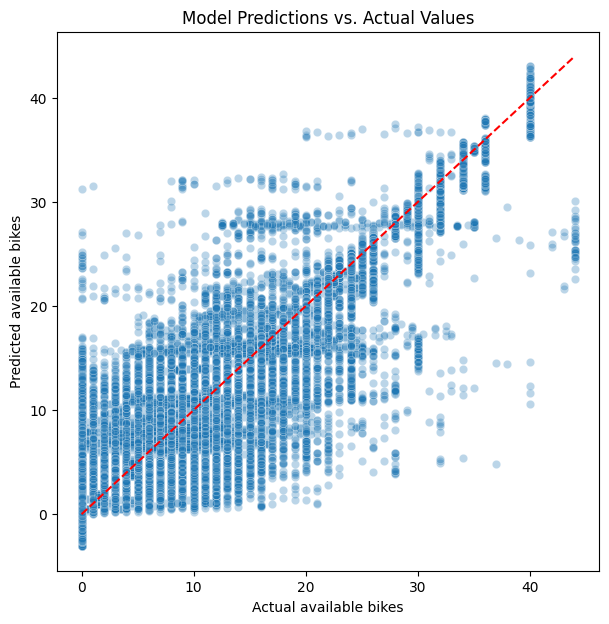

In [34]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred_poly, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual available bikes")
plt.ylabel("Predicted available bikes")
plt.title("Model Predictions vs. Actual Values")
plt.show()

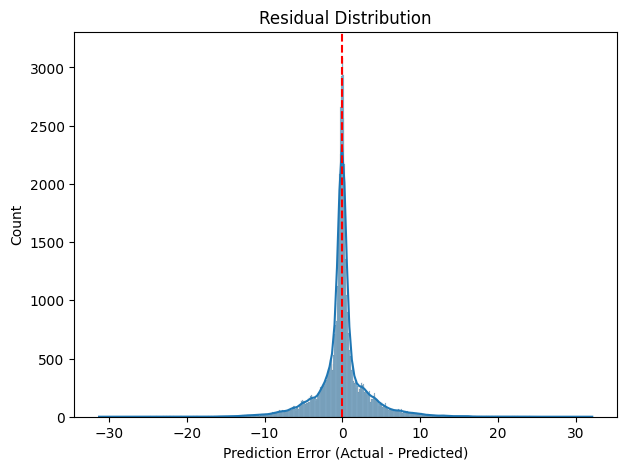

In [35]:
residuals = y_test - y_pred_poly

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True)
plt.axvline(0, color='r', linestyle='--')
plt.title("Residual Distribution")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.show()

In [36]:
residuals.max(), residuals.min()

(np.float64(32.14433447699829), np.float64(-31.28083001435534))

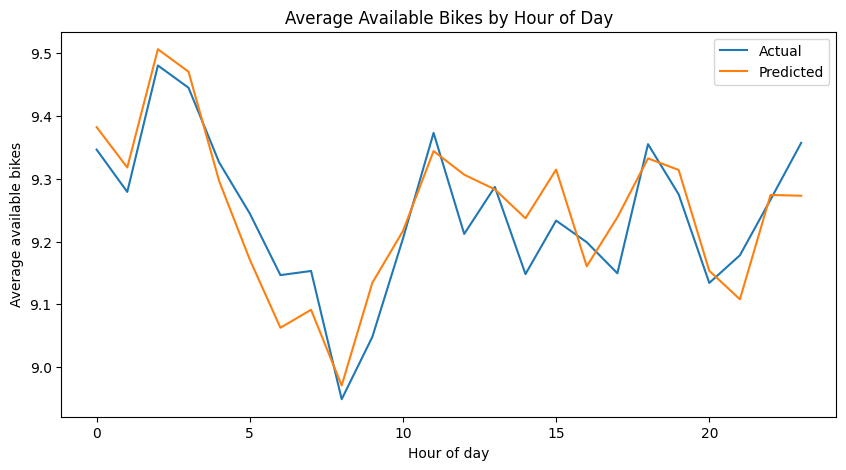

In [37]:
# Add predictions back to test set
X_test_copy = X_test.copy()
X_test_copy['y_true'] = y_test
X_test_copy['y_pred'] = y_pred_poly

# Plot average availability by hour
hourly_avg = X_test_copy.groupby('hour_of_day')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=hourly_avg, x='hour_of_day', y='y_true', label='Actual')
sns.lineplot(data=hourly_avg, x='hour_of_day', y='y_pred', label='Predicted')
plt.title("Average Available Bikes by Hour of Day")
plt.ylabel("Average available bikes")
plt.xlabel("Hour of day")
plt.legend()
plt.show()

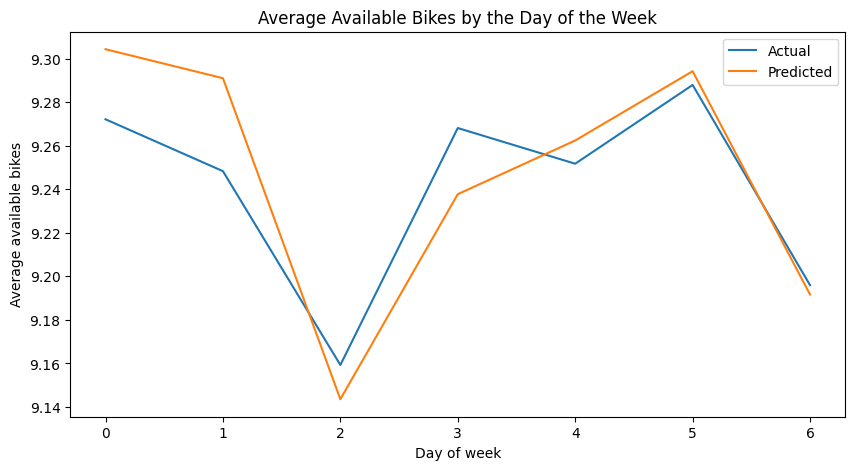

In [38]:
X_test_copy = X_test.copy()
X_test_copy['y_true'] = y_test
X_test_copy['y_pred'] = y_pred_poly

# Plot average availability by hour
daily_avg = X_test_copy.groupby('day_of_week')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=daily_avg, x='day_of_week', y='y_true', label='Actual')
sns.lineplot(data=daily_avg, x='day_of_week', y='y_pred', label='Predicted')
plt.title("Average Available Bikes by the Day of the Week")
plt.ylabel("Average available bikes")
plt.xlabel("Day of week")
plt.legend()
plt.show()

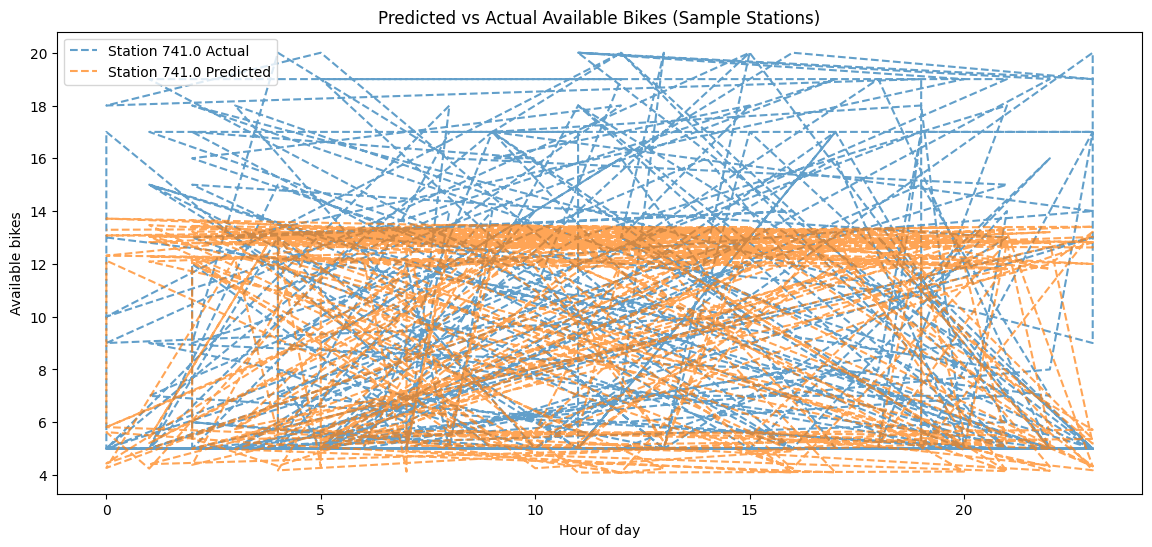

In [39]:
sample_stations = np.random.choice(X_test['station_id'].unique(), size=1, replace=False)

plt.figure(figsize=(14,6))
for station in sample_stations:
    station_data = X_test_copy[X_test_copy['station_id'] == station]
    plt.plot(station_data['hour_of_day'], station_data['y_true'], '--', label=f'Station {station} Actual', alpha=0.7)
    plt.plot(station_data['hour_of_day'], station_data['y_pred'], '--', label=f'Station {station} Predicted', alpha=0.7)

plt.title("Predicted vs Actual Available Bikes (Sample Stations)")
plt.xlabel("Hour of day")
plt.ylabel("Available bikes")
plt.legend()
plt.show()

Already looking way better! But still not as good as it could be....

***

## 2. Adding Lag features AND Using Polynomial Features 

### Adding lag terms (since every consecutive value depends on each other in time series data)

In [40]:
df_lag = df_full.copy()
df_lag['hour'] = pd.to_datetime(df_lag['hour'])

# Sort for lag features
df_lag = df_lag.sort_values(['station_id', 'hour'])

# --- ADD LAG FEATURES ---
df_lag['prev_available'] = df_lag.groupby('station_id')['available_bikes'].shift(1)
df_lag['prev_departures'] = df_lag.groupby('station_id')['departures'].shift(1)
df_lag['prev_arrivals'] = df_lag.groupby('station_id')['arrivals'].shift(1)

# Drop first hour for each station (NaNs)
df_lag = df_lag.dropna(subset=['prev_available', 'prev_departures', 'prev_arrivals'])

# --- FEATURE ENGINEERING ---
df_lag['hour_of_day'] = df_lag['hour'].dt.hour
df_lag['day_of_week'] = df_lag['hour'].dt.dayofweek
df_lag['month'] = df_lag['hour'].dt.month
df_lag['is_weekend'] = (df_lag['day_of_week'] >= 5).astype(int)

In [41]:
# --- Features and Target ---
features = ['station_id', 'hour_of_day', 'day_of_week', 'month', 'is_weekend',
            'departures', 'arrivals', 'capacity',
            'prev_available', 'prev_departures', 'prev_arrivals']
target = 'available_bikes'

X = df_lag[features]
y = df_lag[target]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Preprocessing ---
numeric_features = ['hour_of_day', 'day_of_week', 'month', 'is_weekend',
                    'departures', 'arrivals', 'capacity',
                    'prev_available', 'prev_departures', 'prev_arrivals']
categorical_features = ['station_id']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# --- Linear Regression Model ---
poly = PolynomialFeatures(degree=2, include_bias=False)
model_poly_lag = Pipeline(steps=[
    ('preprocessor', preprocessor),   # Your ColumnTransformer
    ('poly', poly),
    ('regressor', LinearRegression())
])

model_poly_lag.fit(X_train, y_train)
y_pred_poly_lag = model_poly_lag.predict(X_test)

# --- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred_poly_lag))
r2 = r2_score(y_test, y_pred_poly_lag)

print("=== Linear Regression with Lag Features ===")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")


=== Linear Regression with Lag Features ===
RMSE: 0.56
R²: 0.996


R² LOOKS GREAT! But training took 3.5 minutes (this is only for one months worth of data....)

In [58]:
joblib.dump(model_poly_lag, "poly_lag_linreg_model_042019.pkl")
print("Model saved successfully!")

Model saved successfully!


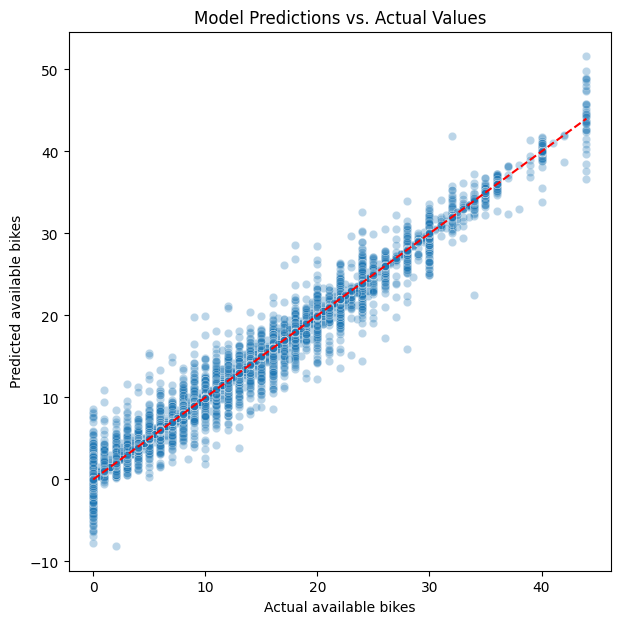

In [42]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred_poly_lag, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual available bikes")
plt.ylabel("Predicted available bikes")
plt.title("Model Predictions vs. Actual Values")
plt.show()

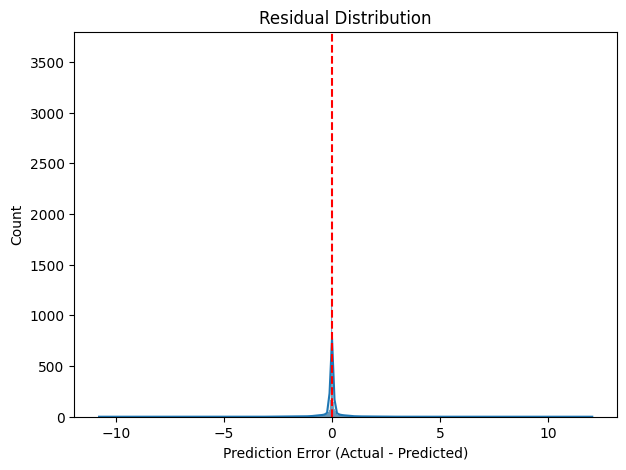

In [43]:
residuals = y_test - y_pred_poly_lag

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True)
plt.axvline(0, color='r', linestyle='--')
plt.title("Residual Distribution")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.show()

In [44]:
residuals.max(), residuals.min()

(np.float64(12.049196593120122), np.float64(-10.771509607419517))

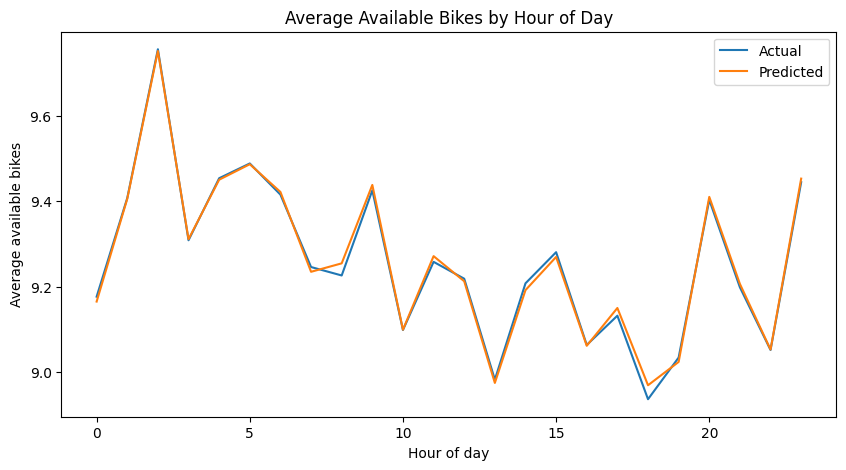

In [45]:
# Add predictions back to test set
X_test_copy = X_test.copy()
X_test_copy['y_true'] = y_test
X_test_copy['y_pred'] = y_pred_poly_lag

# Plot average availability by hour
hourly_avg = X_test_copy.groupby('hour_of_day')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=hourly_avg, x='hour_of_day', y='y_true', label='Actual')
sns.lineplot(data=hourly_avg, x='hour_of_day', y='y_pred', label='Predicted')
plt.title("Average Available Bikes by Hour of Day")
plt.ylabel("Average available bikes")
plt.xlabel("Hour of day")
plt.legend()
plt.show()

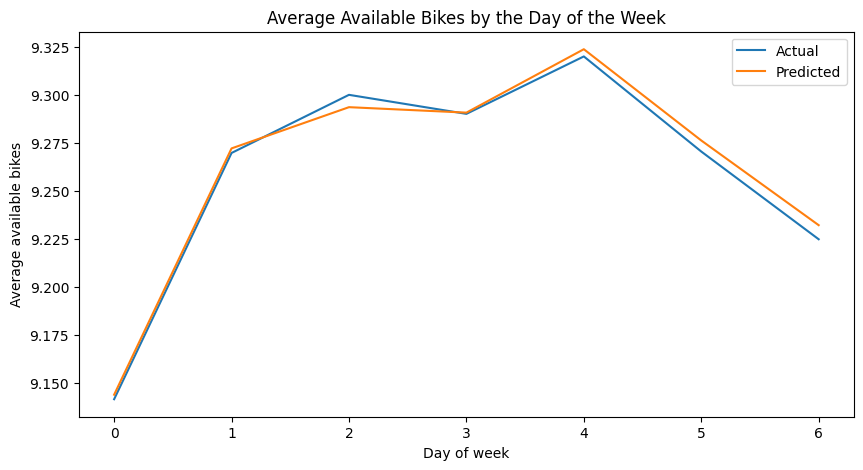

In [46]:
X_test_copy = X_test.copy()
X_test_copy['y_true'] = y_test
X_test_copy['y_pred'] = y_pred_poly_lag

# Plot average availability by hour
daily_avg = X_test_copy.groupby('day_of_week')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=daily_avg, x='day_of_week', y='y_true', label='Actual')
sns.lineplot(data=daily_avg, x='day_of_week', y='y_pred', label='Predicted')
plt.title("Average Available Bikes by the Day of the Week")
plt.ylabel("Average available bikes")
plt.xlabel("Day of week")
plt.legend()
plt.show()

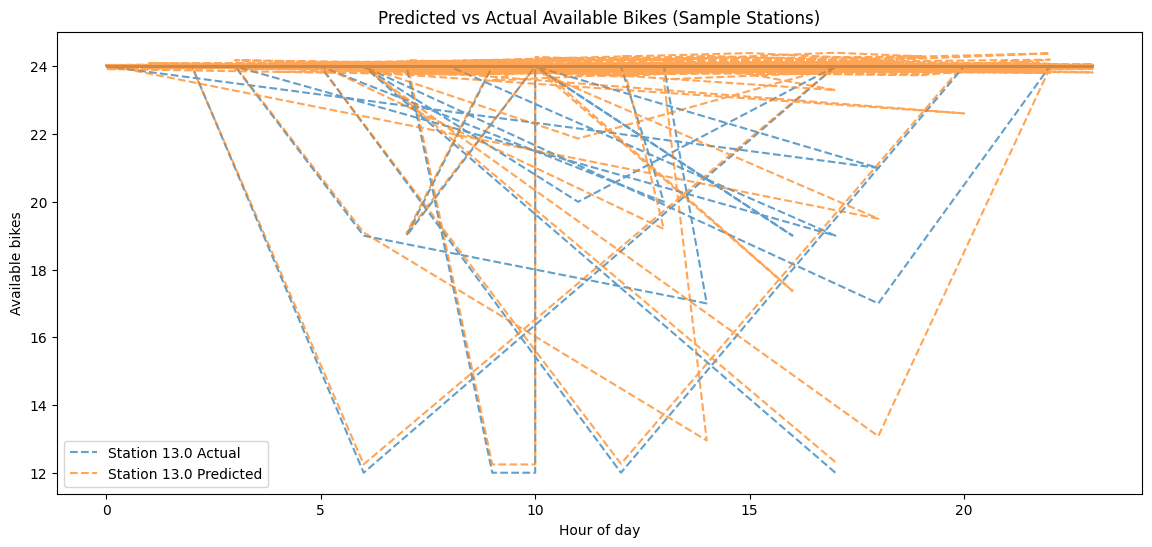

In [47]:
sample_stations = np.random.choice(X_test['station_id'].unique(), size=1, replace=False)

plt.figure(figsize=(14,6))
for station in sample_stations:
    station_data = X_test_copy[X_test_copy['station_id'] == station]
    plt.plot(station_data['hour_of_day'], station_data['y_true'], '--', label=f'Station {station} Actual', alpha=0.7)
    plt.plot(station_data['hour_of_day'], station_data['y_pred'], '--', label=f'Station {station} Predicted', alpha=0.7)

plt.title("Predicted vs Actual Available Bikes (Sample Stations)")
plt.xlabel("Hour of day")
plt.ylabel("Available bikes")
plt.legend()
plt.show()

I think we found our model!!

***

### Ridge regression is just linear regression but with a penalty to avoid noisy data from making the coef too large --> smoother and more generalized

In [53]:
poly = PolynomialFeatures(degree=2, include_bias=False)

# --- Ridge Regression Model ---
ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', poly),
    ('regressor', Ridge(alpha=1.0))
])

# Train
ridge_model.fit(X_train, y_train)

# Predict
y_pred_ridge = ridge_model.predict(X_test)

# --- Evaluate ---
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print("\n=== Ridge Regression with Lag and Polynomial Features ===")
print(f"RMSE: {rmse_ridge:.2f}")
print(f"R²: {r2_ridge:.3f}")



=== Ridge Regression with Lag and Polynomial Features ===
RMSE: 0.56
R²: 0.996


In [59]:
joblib.dump(ridge_model, "poly_lag_ridge_model_042019.pkl")
print("Model saved successfully!")

Model saved successfully!


In [54]:
comparison = pd.DataFrame({
    'Model': ['Linear (with lags+poly)', 'Ridge (with lags+poly)'],
    'RMSE': [rmse, rmse_ridge],
    'R²': [r2, r2_ridge]
})

print(comparison)


                     Model      RMSE        R²
0  Linear (with lags+poly)  0.562734  0.995902
1   Ridge (with lags+poly)  0.563861  0.995886


## Gives SLIGHTLY worse results (expected kinda cus of the penalty term added), but takes half the time

In [ ]:
available bikes: 6
empty spots = 12
total capacity of station: 20

***

In [23]:
df_lag = df_full.copy()
df_lag['hour'] = pd.to_datetime(df_lag['hour'])

# Sort for lag features
df_lag = df_lag.sort_values(['station_id', 'hour'])

# --- ADD LAG FEATURES ---
df_lag['prev_available'] = df_lag.groupby('station_id')['available_bikes'].shift(1)
df_lag['prev_departures'] = df_lag.groupby('station_id')['departures'].shift(1)
df_lag['prev_arrivals'] = df_lag.groupby('station_id')['arrivals'].shift(1)

# Drop first hour for each station (NaNs)
df_lag = df_lag.dropna(subset=['prev_available', 'prev_departures', 'prev_arrivals'])

# --- FEATURE ENGINEERING ---
df_lag['hour_of_day'] = df_lag['hour'].dt.hour
df_lag['day_of_week'] = df_lag['hour'].dt.dayofweek
df_lag['month'] = df_lag['hour'].dt.month
df_lag['is_weekend'] = (df_lag['day_of_week'] >= 5).astype(int)

train, test = train_test_split(df_lag, test_size=0.2, random_state=42)

(train).to_csv("df_lag_train_042019.csv")
(test).to_csv("df_lag_test_042019.csv")


In [17]:
# train, test = train_test_split(df_lag, test_size=0.2, random_state=42)

In [24]:
train.shape, test.shape, df_lag.shape, train.shape[0] + test.shape[0]

((332051, 15), (83013, 15), (415064, 15), 415064)

In [26]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
import joblib
import gc

# === CONFIG ===
DATA_PATH = "df_lag_train_042019.csv"
MODEL_PATH = "SGDmodel_test.pkl"
BATCH_SIZE = 100_000  # adjust depending on your RAM
POLY_DEGREE = 2

# === FEATURE COLUMNS ===
numeric_features = [
    'hour_of_day', 'day_of_week', 'month', 'is_weekend',
    'departures', 'arrivals', 'capacity',
    'prev_available', 'prev_departures', 'prev_arrivals'
]
categorical_features = ['station_id']
target = 'available_bikes'

# === PREPARE TRANSFORMERS ===
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
poly = PolynomialFeatures(degree=POLY_DEGREE, include_bias=False)

# === INITIALIZE MODEL ===
model = SGDRegressor(loss="squared_error", penalty="l2", alpha=0.001, max_iter=1)

# === TRAIN IN BATCHES ===
iterator = pd.read_csv(DATA_PATH, chunksize=BATCH_SIZE)

print("Training incremental polynomial regression model in batches...")

first = True
for i, chunk in enumerate(iterator):
    chunk = chunk.dropna(subset=numeric_features + categorical_features + [target])
    chunk = shuffle(chunk, random_state=42)

    X_num = chunk[numeric_features].astype(float)
    X_cat = chunk[categorical_features].astype(str)
    y_batch = chunk[target].values

    # --- SCALE NUMERICAL FEATURES ---
    if first:
        X_num_scaled = scaler.fit_transform(X_num)
    else:
        X_num_scaled = scaler.transform(X_num)

    # --- ENCODE CATEGORICAL FEATURES ---
    if first:
        X_cat_encoded = encoder.fit_transform(X_cat)
    else:
        X_cat_encoded = encoder.transform(X_cat)

    # --- COMBINE NUMERIC + CATEGORICAL ---
    from scipy.sparse import hstack
    X_combined = hstack([X_num_scaled, X_cat_encoded]).tocsr()

    # --- ADD POLYNOMIAL FEATURES (careful with memory!) ---
    # For sparse matrices, PolynomialFeatures can explode in size, so we limit it
    # to numeric columns only for tractability.
    X_poly = poly.fit_transform(X_num_scaled) if first else poly.transform(X_num_scaled)

    X_full = np.hstack([X_poly, X_combined.toarray()[:, :10]])  # use subset to limit memory

    # --- TRAIN INCREMENTALLY ---
    model.partial_fit(X_full, y_batch)

    print(f"✅ Trained on batch {i+1}, rows: {len(chunk)}")

    # --- MEMORY MANAGEMENT ---
    del chunk, X_num, X_cat, X_combined, X_poly, X_full
    gc.collect()

    first = False

# === SAVE MODEL + TRANSFORMERS ===
joblib.dump({
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'poly': poly
}, MODEL_PATH)
print(f"✅ Model and preprocessors saved to {MODEL_PATH}")

Training incremental polynomial regression model in batches...
✅ Trained on batch 1, rows: 100000
✅ Trained on batch 2, rows: 100000
✅ Trained on batch 3, rows: 100000
✅ Trained on batch 4, rows: 32051
✅ Model and preprocessors saved to SGDmodel_test.pkl


In [36]:
import joblib
import numpy as np
from scipy.sparse import hstack

# === FEATURE COLUMNS ===
numeric_features = [
    'hour_of_day', 'day_of_week', 'month', 'is_weekend',
    'departures', 'arrivals', 'capacity',
    'prev_available', 'prev_departures', 'prev_arrivals'
]
categorical_features = ['station_id']
target = 'available_bikes'

bundle = joblib.load("/home/rishika/Intro_to_DS/MiniProject/DS_mini_project/SGDmodel_test.pkl")
model = bundle['model']
scaler = bundle['scaler']
encoder = bundle['encoder']
poly = bundle['poly']

# Example input
# sample = {
#     'station_id': ['1'],
#     'hour_of_day': [8],
#     'day_of_week': [2],
#     'month': [4],
#     'is_weekend': [0],
#     'departures': [5],
#     'arrivals': [3],
#     'capacity': [20],
#     'prev_available': [10],
#     'prev_departures': [4],
#     'prev_arrivals': [2]
# }
sample = pd.read_csv("df_lag_test_042019.csv")
import pandas as pd
X_sample = pd.DataFrame(sample[numeric_features + categorical_features])

# Transform features
X_num = scaler.transform(X_sample[numeric_features])
X_cat = encoder.transform(X_sample[categorical_features].astype(int).astype(str))
X_combined = hstack([X_num, X_cat]).tocsr()
X_poly = poly.transform(X_num)
X_full = np.hstack([X_poly, X_combined.toarray()[:, :10]])

# Predict
# X_sample = X_sample.tocsr()
pred = model.predict(X_full)
print("Predicted available bikes:", pred)

Predicted available bikes: [-3.50625342e+10  1.16392554e+11  7.21278440e+10 ...  1.66209213e+10
 -2.12435021e+10  1.19874946e+10]


In [34]:
sample

Unnamed: 0  station_id                 hour  departures  arrivals  \
0          322728       559.0  2019-05-01 15:00:00         0.0       0.0   
1          286707       505.0  2019-04-15 19:00:00         2.0       2.0   
2           30782        27.0  2019-04-03 14:00:00         3.0       2.0   
3          333716       581.0  2019-04-28 14:00:00         5.0      10.0   
4           67145        56.0  2019-05-03 16:00:00         0.0       0.0   
...           ...         ...                  ...         ...       ...   
83008       54543        46.0  2019-04-20 16:00:00         5.0       2.0   
83009      104106        86.0  2019-05-07 11:00:00         0.0       0.0   
83010      169344       143.0  2019-05-11 16:00:00         0.0       0.0   
83011       21805        19.0  2019-05-09 05:00:00         0.0       0.0   
83012       15633        14.0  2019-05-08 02:00:00         0.0       0.0   

       capacity  net_flow  available_bikes  empty  hour_of_day  day_of_week  \
0          25.0       0.0              0.0      1           15            2   
1          16.0       0.0              0.0      1           19            0   
2          14.0      -1.0              9.0      0           14            2   
3          35.0       5.0             35.0      0           14            6   
4          12.0       0.0             12.0      0           16            4   
...         ...       ...              ...    ...          ...          ...   
83008      16.0      -3.0              0.0      1           16            5   
83009      24.0       0.0              0.0      1           11            1   
83010      12.0       0.0              8.0      0           16            5   
83011      20.0       0.0              0.0      1            5            3   
83012      22.0       0.0             22.0      0            2            2   

       month  is_weekend  prev_available  prev_departures  prev_arrivals  
0          5           0             0.0              0.0            0.0  
1          4           0             0.0              3.0            1.0  
2          4           0            10.0              3.0            4.0  
3          4           1            35.0              5.0            3.0  
4          5           0            12.0              0.0            0.0  
...      ...         ...             ...              ...            ...  
83008      4           1             0.0              9.0            3.0  
83009      5           0             0.0              0.0            0.0  
83010      5           1             8.0              0.0            0.0  
83011      5           0             0.0              0.0            0.0  
83012      5           0            22.0              0.0            0.0  

[83013 rows x 16 columns]

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

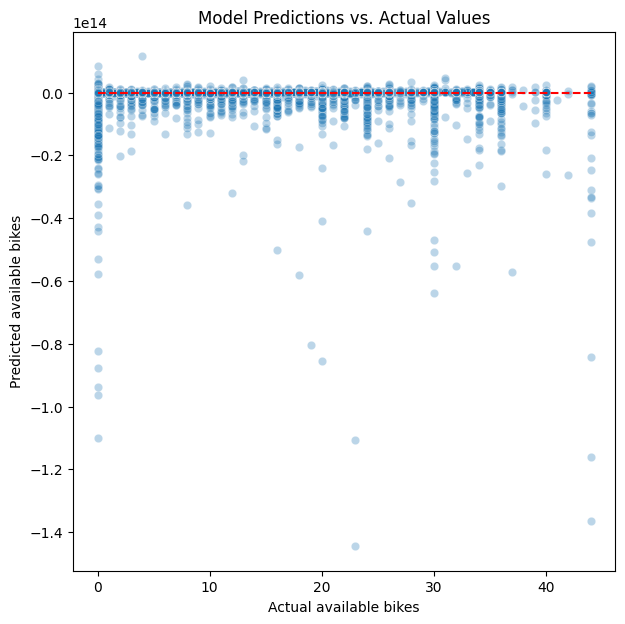

In [41]:
y_test=sample['available_bikes']
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual available bikes")
plt.ylabel("Predicted available bikes")
plt.title("Model Predictions vs. Actual Values")
plt.show()

In [42]:
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print("=== Linear Regression with Lag Features ===")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

=== Linear Regression with Lag Features ===
RMSE: 1725896468079.86
R²: -38543324108026613334016.000


In [43]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
import joblib
import gc

# === CONFIG ===
DATA_PATH = "df_lag_train_042019.csv"
MODEL_PATH = "SGDmodel_pipeline.pkl"
BATCH_SIZE = 100_000
POLY_DEGREE = 2

# === FEATURE COLUMNS ===
numeric_features = [
    'hour_of_day', 'day_of_week', 'month', 'is_weekend',
    'departures', 'arrivals', 'capacity',
    'prev_available', 'prev_departures', 'prev_arrivals'
]
categorical_features = ['station_id']
target = 'available_bikes'

# === PIPELINE ===
# numeric_pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('poly', PolynomialFeatures(degree=POLY_DEGREE, include_bias=False))
# ])

numeric_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

categorical_pipe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, numeric_features),
    ('cat', categorical_pipe, categorical_features)
])

model = SGDRegressor(loss='squared_error', penalty='l2', alpha=0.001, max_iter=1, warm_start=True)

# === TRAIN IN BATCHES ===
iterator = pd.read_csv(DATA_PATH, chunksize=BATCH_SIZE)

print("Training incremental regression model in batches...")

first_batch = True
for i, chunk in enumerate(iterator):
    chunk = chunk.dropna(subset=numeric_features + categorical_features + [target])
    chunk = shuffle(chunk, random_state=42)

    X_chunk = chunk[numeric_features + categorical_features]
    y_chunk = chunk[target].values

    # Fit or transform the preprocessor
    if first_batch:
        X_transformed = preprocessor.fit_transform(X_chunk)
    else:
        X_transformed = preprocessor.transform(X_chunk)

    # Incremental training
    model.partial_fit(X_transformed, y_chunk)

    print(f"✅ Trained on batch {i+1}, rows: {len(chunk)}")

    # Memory cleanup
    del chunk, X_chunk, X_transformed
    gc.collect()

    first_batch = False

# === SAVE MODEL + PREPROCESSOR ===
joblib.dump({
    'model': model,
    'preprocessor': preprocessor
}, MODEL_PATH)
print(f"✅ Model and preprocessor saved to {MODEL_PATH}")




Training incremental regression model in batches...
✅ Trained on batch 1, rows: 100000
✅ Trained on batch 2, rows: 100000
✅ Trained on batch 3, rows: 100000
✅ Trained on batch 4, rows: 32051
✅ Model and preprocessor saved to SGDmodel_pipeline.pkl


In [44]:
# === PREDICTION EXAMPLE ===
sample = pd.read_csv("df_lag_test_042019.csv")
X_sample = sample[numeric_features + categorical_features]

bundle = joblib.load(MODEL_PATH)
model = bundle['model']
preprocessor = bundle['preprocessor']

X_transformed = preprocessor.transform(X_sample)
predictions = model.predict(X_transformed)

print("Predicted available bikes:", predictions)

Predicted available bikes: [-1.73676920e+09 -1.24565199e+10  1.28612176e+10 ...  5.25947910e+10
 -1.85892691e+10 -3.16002459e+10]


In [45]:
y_test=sample['available_bikes']
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print("=== Linear Regression with Lag Features ===")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

=== Linear Regression with Lag Features ===
RMSE: 402059014483.83
R²: -2091699509509847777280.000


In [104]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
import joblib
import gc

# === CONFIG ===
DATA_PATH = "df_lag_train_042019.csv"
MODEL_PATH = "SGDmodel_stable2.pkl"
BATCH_SIZE = 100_000

# === FEATURE COLUMNS ===
numeric_features = [
    'hour_of_day', 'day_of_week', 'month', 'is_weekend',
    'departures', 'arrivals', 'capacity',
    'prev_available', 'prev_departures', 'prev_arrivals'
]
categorical_features = ['station_id']
target = 'available_bikes'

# === PIPELINE ===
numeric_pipe = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, numeric_features),
    ('cat', categorical_pipe, categorical_features)
])

# Use stable SGD parameters
model = SGDRegressor(
    loss='squared_error',
    penalty='l2',
    alpha=0.001,             # regularization
    learning_rate='invscaling',
    eta0=0.01,              # initial learning rate
    max_iter=1,
    warm_start=True,
    fit_intercept=True
)

# === TRAIN IN BATCHES ===
iterator = pd.read_csv(DATA_PATH, chunksize=BATCH_SIZE)

print("Training incremental regression model in batches...")

first_batch = True
for i, chunk in enumerate(iterator):
    chunk = chunk.dropna(subset=numeric_features + categorical_features + [target])
    chunk = shuffle(chunk, random_state=42)

    X_chunk = chunk[numeric_features + categorical_features]
    y_chunk = chunk[target].values

    # Fit or transform the preprocessor
    if first_batch:
        X_transformed = preprocessor.fit_transform(X_chunk)
    else:
        X_transformed = preprocessor.transform(X_chunk)

    # Incremental training
    model.partial_fit(X_transformed, y_chunk)

    print(f"✅ Trained on batch {i+1}, rows: {len(chunk)}")

    # Memory cleanup
    del chunk, X_chunk, X_transformed
    gc.collect()

    first_batch = False

# === SAVE MODEL + PREPROCESSOR ===
joblib.dump({
    'model': model,
    'preprocessor': preprocessor
}, MODEL_PATH)
print(f"✅ Model and preprocessor saved to {MODEL_PATH}")

# === PREDICTION EXAMPLE ===
sample = pd.read_csv("df_lag_test_042019.csv")
X_sample = sample[numeric_features + categorical_features]

bundle = joblib.load(MODEL_PATH)
model = bundle['model']
preprocessor = bundle['preprocessor']

X_transformed = preprocessor.transform(X_sample)
predictions = model.predict(X_transformed)

print("Predicted available bikes:", predictions)



Training incremental regression model in batches...


✅ Trained on batch 1, rows: 100000
✅ Trained on batch 2, rows: 100000
✅ Trained on batch 3, rows: 100000
✅ Trained on batch 4, rows: 32051
✅ Model and preprocessor saved to SGDmodel_stable2.pkl
Predicted available bikes: [-0.79340016 -0.79263439  8.77025551 ...  7.07357854 -0.92994844
 21.01632195]


In [105]:
y_mean = train[target].mean()
predictions += y_mean - predictions.mean() #to unshift everything

In [112]:
X_sample

hour_of_day  day_of_week  month  is_weekend  departures  arrivals  \
0               15            2      5           0         0.0       0.0   
1               19            0      4           0         2.0       2.0   
2               14            2      4           0         3.0       2.0   
3               14            6      4           1         5.0      10.0   
4               16            4      5           0         0.0       0.0   
...            ...          ...    ...         ...         ...       ...   
83008           16            5      4           1         5.0       2.0   
83009           11            1      5           0         0.0       0.0   
83010           16            5      5           1         0.0       0.0   
83011            5            3      5           0         0.0       0.0   
83012            2            2      5           0         0.0       0.0   

       capacity  prev_available  prev_departures  prev_arrivals  station_id  
0          25.0             0.0              0.0            0.0       559.0  
1          16.0             0.0              3.0            1.0       505.0  
2          14.0            10.0              3.0            4.0        27.0  
3          35.0            35.0              5.0            3.0       581.0  
4          12.0            12.0              0.0            0.0        56.0  
...         ...             ...              ...            ...         ...  
83008      16.0             0.0              9.0            3.0        46.0  
83009      24.0             0.0              0.0            0.0        86.0  
83010      12.0             8.0              0.0            0.0       143.0  
83011      20.0             0.0              0.0            0.0        19.0  
83012      22.0            22.0              0.0            0.0        14.0  

[83013 rows x 11 columns]

In [115]:
predictions

array([ 0.164493  ,  0.16525876,  9.72814867, ...,  8.0314717 ,
        0.02794471, 21.9742151 ], shape=(83013,))

In [98]:
# predictions -= y_mean - predictions.mean()

In [127]:
y_test=sample['available_bikes']
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print("=== Linear Regression with Lag Features ===")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

=== Linear Regression with Lag Features ===
RMSE: 0.70
R²: 0.994


In [116]:
pred2 = np.clip(predictions, 0, X_sample['capacity'])

In [120]:
predictions = np.clip(predictions, 0, X_sample['capacity'].to_numpy())


In [121]:
predictions

array([ 0.164493  ,  0.16525876,  9.72814867, ...,  8.0314717 ,
        0.02794471, 21.9742151 ], shape=(83013,))

In [118]:
predictions

array([ 0.164493  ,  0.16525876,  9.72814867, ...,  8.0314717 ,
        0.02794471, 21.9742151 ], shape=(83013,))

In [109]:
y_test

0         0.0
1         0.0
2         9.0
3        35.0
4        12.0
         ... 
83008     0.0
83009     0.0
83010     8.0
83011     0.0
83012    22.0
Name: available_bikes, Length: 83013, dtype: float64

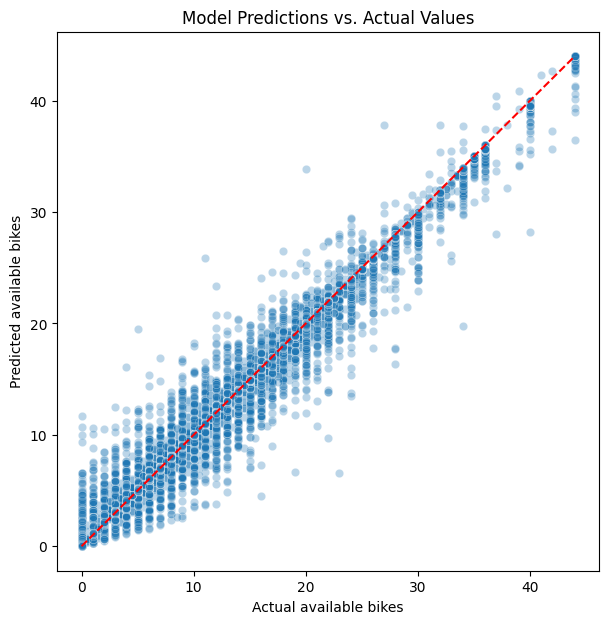

In [123]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual available bikes")
plt.ylabel("Predicted available bikes")
plt.title("Model Predictions vs. Actual Values")
plt.show()

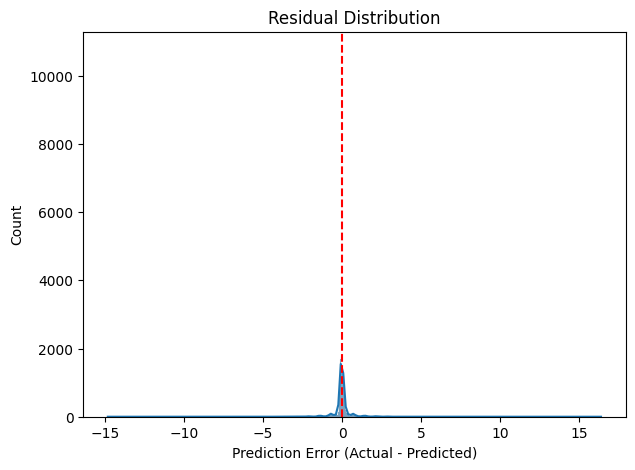

In [124]:

residuals = y_test - predictions

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True)
plt.axvline(0, color='r', linestyle='--')
plt.title("Residual Distribution")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.show()

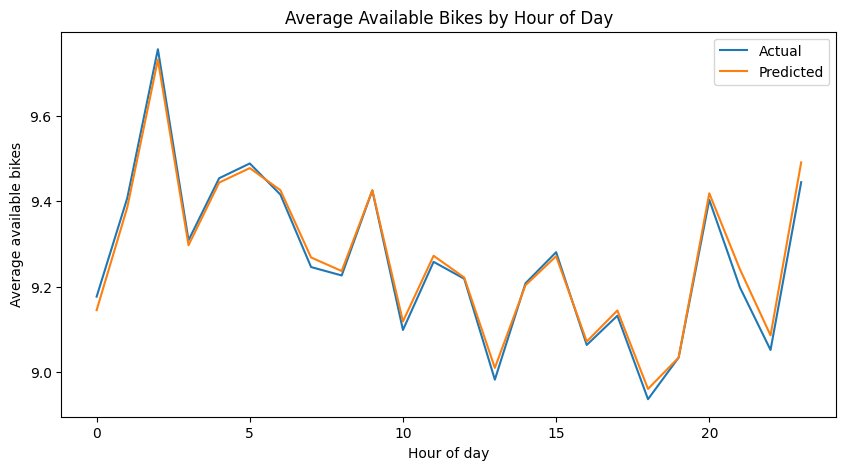

In [125]:
# Add predictions back to test set
X_test_copy = X_sample.copy()
X_test_copy['y_true'] = y_test
X_test_copy['y_pred'] = predictions

# Plot average availability by hour
hourly_avg = X_test_copy.groupby('hour_of_day')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=hourly_avg, x='hour_of_day', y='y_true', label='Actual')
sns.lineplot(data=hourly_avg, x='hour_of_day', y='y_pred', label='Predicted')
plt.title("Average Available Bikes by Hour of Day")
plt.ylabel("Average available bikes")
plt.xlabel("Hour of day")
plt.legend()
plt.show()

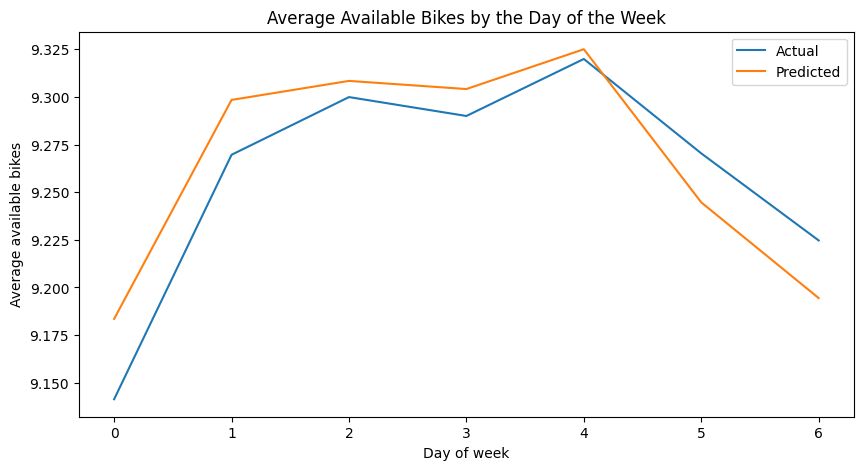

In [126]:
X_test_copy = X_sample.copy()
X_test_copy['y_true'] = y_test
X_test_copy['y_pred'] = predictions

# Plot average availability by hour
daily_avg = X_test_copy.groupby('day_of_week')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=daily_avg, x='day_of_week', y='y_true', label='Actual')
sns.lineplot(data=daily_avg, x='day_of_week', y='y_pred', label='Predicted')
plt.title("Average Available Bikes by the Day of the Week")
plt.ylabel("Average available bikes")
plt.xlabel("Day of week")
plt.legend()
plt.show()

***

In [131]:
df_lag_full = pd.read_csv("full_df_lag.csv")
train_full, test_full = train_test_split(df_lag_full, test_size=0.2, random_state=42)

(train_full).to_csv("full_df_lag_train.csv")
(test_full).to_csv("full_df_lag_validation.csv")

In [133]:
train_full.shape, test_full.shape, df_lag_full.shape, train_full.shape[0] + test_full.shape[0]

((6138770, 18), (1534693, 18), (7673463, 18), 7673463)

In [134]:
predictions = np.load("/home/rishika/Intro_to_DS/MiniProject/SGD_stable_preds_for_validation.npy")

In [135]:
y_test=test_full['available_bikes']
X_sample = test_full[numeric_features + categorical_features]
y_mean = train_full[target].mean()
predictions += y_mean - predictions.mean() #to unshift everything

In [136]:
predictions = np.clip(predictions, 0, X_sample['capacity'].to_numpy())


In [ ]:
np.save("SGD_stable_preds_for_validation.npy", predictions)

: 

In [143]:
predictions = np.load("SGD_stable_preds_for_validation.npy")

In [144]:
predictions

array([ 7.99389786,  0.02702126,  8.00197471, ..., 19.97914466,
       10.00399476,  6.99122974], shape=(1534693,))

In [146]:
numeric_features = [
    'hour_of_day', 'day_of_week', 'month', 'is_weekend', 'year',
    'departures', 'arrivals', 'capacity',
    'prev_available', 'prev_departures', 'prev_arrivals'
]
categorical_features = ['station_id']
target = 'available_bikes'

test_full = pd.read_csv("/home/rishika/Intro_to_DS/MiniProject/DS_mini_project/full_df_lag_validation.csv")
y_test=test_full['available_bikes']
X_sample = test_full[numeric_features + categorical_features]

In [147]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print("=== Linear Regression with Lag Features ===")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

=== Linear Regression with Lag Features ===
RMSE: 0.29
R²: 0.999


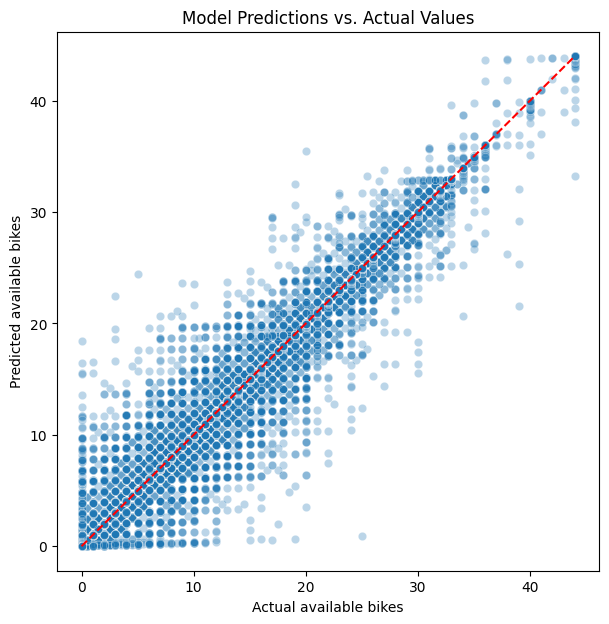

In [148]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual available bikes")
plt.ylabel("Predicted available bikes")
plt.title("Model Predictions vs. Actual Values")
plt.show()

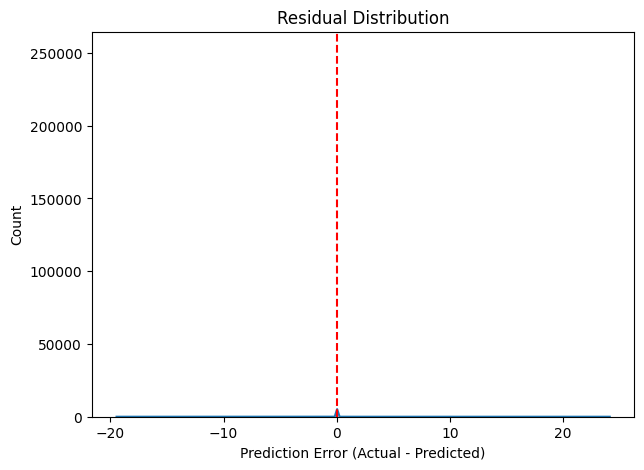

In [149]:

residuals = y_test - predictions

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True)
plt.axvline(0, color='r', linestyle='--')
plt.title("Residual Distribution")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.show()

In [150]:
residuals.max(), residuals.min()

(np.float64(24.12131732016832), np.float64(-19.460785495126693))

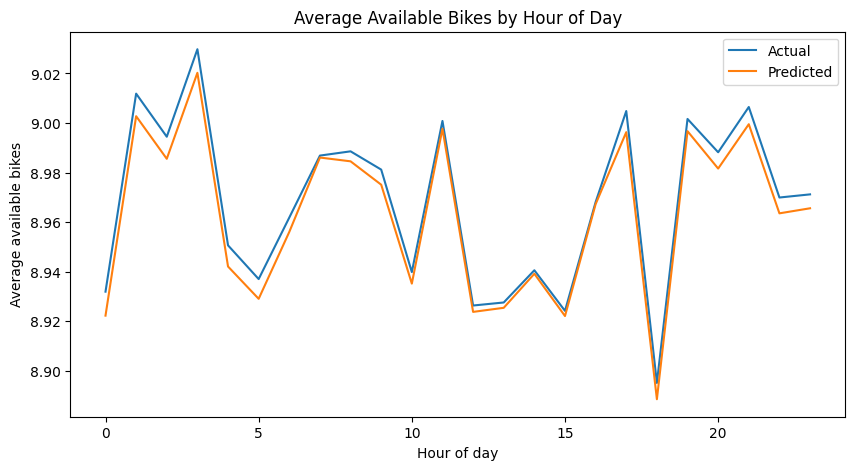

In [151]:
# Add predictions back to test set
X_test_copy = X_sample.copy()
X_test_copy['y_true'] = y_test
X_test_copy['y_pred'] = predictions

# Plot average availability by hour
hourly_avg = X_test_copy.groupby('hour_of_day')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=hourly_avg, x='hour_of_day', y='y_true', label='Actual')
sns.lineplot(data=hourly_avg, x='hour_of_day', y='y_pred', label='Predicted')
plt.title("Average Available Bikes by Hour of Day")
plt.ylabel("Average available bikes")
plt.xlabel("Hour of day")
plt.legend()
plt.show()

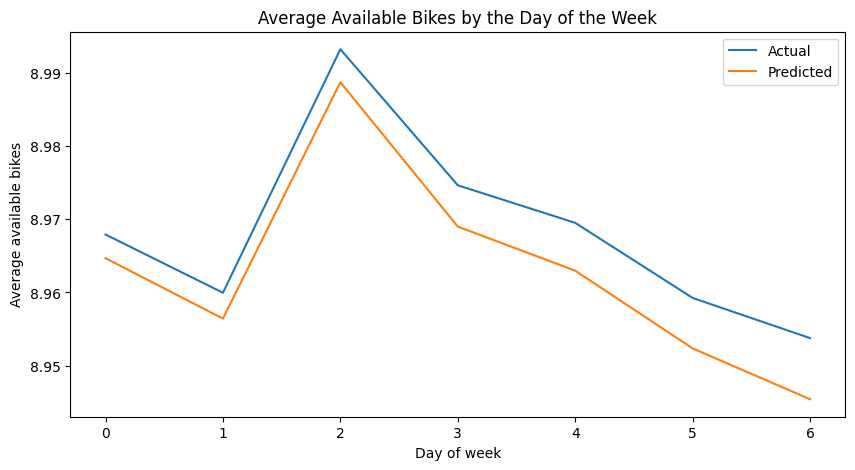

In [141]:
X_test_copy = X_sample.copy()
X_test_copy['y_true'] = y_test
X_test_copy['y_pred'] = predictions

# Plot average availability by hour
daily_avg = X_test_copy.groupby('day_of_week')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=daily_avg, x='day_of_week', y='y_true', label='Actual')
sns.lineplot(data=daily_avg, x='day_of_week', y='y_pred', label='Predicted')
plt.title("Average Available Bikes by the Day of the Week")
plt.ylabel("Average available bikes")
plt.xlabel("Day of week")
plt.legend()
plt.show()

***

## TRYING WITH WEATHER (FAIL)

In [2]:
import pandas as pd
df_lag = pd.read_csv("df_lag_train_042019.csv")
df_lag

Unnamed: 0  station_id                 hour  departures  arrivals  \
0           297968       521.0  2019-04-24 03:00:00         0.0       0.0   
1           156849       133.0  2019-05-03 03:00:00         0.0       0.0   
2            23002        20.0  2019-05-07 21:00:00         0.0       0.0   
3             5515         5.0  2019-04-26 04:00:00         0.0       0.0   
4           238510       248.0  2019-04-04 17:00:00         0.0       0.0   
...            ...         ...                  ...         ...       ...   
332046      259390       266.0  2019-04-04 04:00:00         0.0       0.0   
332047      366136       635.0  2019-05-18 00:00:00         0.0       0.0   
332048      132040       112.0  2019-04-23 14:00:00         5.0       4.0   
332049      146987       125.0  2019-05-01 21:00:00         0.0       0.0   
332050      122058       104.0  2019-04-17 08:00:00         2.0       0.0   

        capacity  net_flow  available_bikes  empty  hour_of_day  day_of_week  \
0           30.0       0.0              0.0      1            3            2   
1           22.0       0.0              0.0      1            3            4   
2           22.0       0.0             22.0      0           21            1   
3           32.0       0.0              0.0      1            4            4   
4           16.0       0.0              8.0      0           17            3   
...          ...       ...              ...    ...          ...          ...   
332046      14.0       0.0              7.0      0            4            3   
332047      24.0       0.0              0.0      1            0            5   
332048      22.0      -1.0              0.0      1           14            1   
332049      16.0       0.0              5.0      0           21            2   
332050      16.0      -2.0             12.0      0            8            2   

        month  is_weekend  prev_available  prev_departures  prev_arrivals  
0           4           0             0.0              0.0            0.0  
1           5           0             0.0              0.0            0.0  
2           5           0            22.0              0.0            0.0  
3           4           0             0.0              0.0            0.0  
4           4           0             8.0              0.0            0.0  
...       ...         ...             ...              ...            ...  
332046      4           0             7.0              0.0            0.0  
332047      5           1             0.0              0.0            0.0  
332048      4           0             0.0              9.0            1.0  
332049      5           0             5.0              0.0            0.0  
332050      4           0            14.0              2.0            0.0  

[332051 rows x 16 columns]

In [3]:
weather = pd.read_csv("/home/rishika/Intro_to_DS/MiniProject/data/espoo_rain_042019.csv")
weather

Observation station  Year  Month  Day Time [Local time]  \
0         Espoo Tapiola  2019      4    1             00:00   
1         Espoo Tapiola  2019      4    1             01:00   
2         Espoo Tapiola  2019      4    1             02:00   
3         Espoo Tapiola  2019      4    1             03:00   
4         Espoo Tapiola  2019      4    1             04:00   
..                  ...   ...    ...  ...               ...   
715       Espoo Tapiola  2019      4   30             19:00   
716       Espoo Tapiola  2019      4   30             20:00   
717       Espoo Tapiola  2019      4   30             21:00   
718       Espoo Tapiola  2019      4   30             22:00   
719       Espoo Tapiola  2019      4   30             23:00   

     Precipitation [mm]  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
..                  ...  
715                 0.0  
716                 0.0  
717                 0.0  
718                 0.0  
719                 0.0  

[720 rows x 6 columns]

In [7]:
rain = weather.copy()
type(rain['Time [Local time]'][0]) # = rain['Time [Local time]'].split(":")[0].astype(int)
# rain

str

In [9]:
rain['hour_of_day'] = rain['Time [Local time]'].str.split(':').str[0].astype(int)
rain


Observation station  Year  Month  Day Time [Local time]  \
0         Espoo Tapiola  2019      4    1             00:00   
1         Espoo Tapiola  2019      4    1             01:00   
2         Espoo Tapiola  2019      4    1             02:00   
3         Espoo Tapiola  2019      4    1             03:00   
4         Espoo Tapiola  2019      4    1             04:00   
..                  ...   ...    ...  ...               ...   
715       Espoo Tapiola  2019      4   30             19:00   
716       Espoo Tapiola  2019      4   30             20:00   
717       Espoo Tapiola  2019      4   30             21:00   
718       Espoo Tapiola  2019      4   30             22:00   
719       Espoo Tapiola  2019      4   30             23:00   

     Precipitation [mm]  hour_of_day  
0                   0.0            0  
1                   0.0            1  
2                   0.0            2  
3                   0.0            3  
4                   0.0            4  
..                  ...          ...  
715                 0.0           19  
716                 0.0           20  
717                 0.0           21  
718                 0.0           22  
719                 0.0           23  

[720 rows x 7 columns]

In [14]:
rain['rained'] = (rain['Precipitation [mm]'] > 0).astype(int)
rain

Observation station  Year  Month  Day Time [Local time]  \
0         Espoo Tapiola  2019      4    1             00:00   
1         Espoo Tapiola  2019      4    1             01:00   
2         Espoo Tapiola  2019      4    1             02:00   
3         Espoo Tapiola  2019      4    1             03:00   
4         Espoo Tapiola  2019      4    1             04:00   
..                  ...   ...    ...  ...               ...   
715       Espoo Tapiola  2019      4   30             19:00   
716       Espoo Tapiola  2019      4   30             20:00   
717       Espoo Tapiola  2019      4   30             21:00   
718       Espoo Tapiola  2019      4   30             22:00   
719       Espoo Tapiola  2019      4   30             23:00   

     Precipitation [mm]  hour_of_day  rained  
0                   0.0            0       0  
1                   0.0            1       0  
2                   0.0            2       0  
3                   0.0            3       0  
4                   0.0            4       0  
..                  ...          ...     ...  
715                 0.0           19       0  
716                 0.0           20       0  
717                 0.0           21       0  
718                 0.0           22       0  
719                 0.0           23       0  

[720 rows x 8 columns]

In [15]:
import pandas as pd

# Example DataFrame (yours)
# df = your existing dataframe

# 1️⃣ Combine the year, month, day, and time columns into one datetime column
rain['datetime'] = pd.to_datetime(
    rain['Year'].astype(str) + '-' +
    rain['Month'].astype(str) + '-' +
    rain['Day'].astype(str) + ' ' +
    rain['Time [Local time]']
)

# 2️⃣ Now extract the useful datetime components
rain['hour_of_day'] = rain['datetime'].dt.hour
rain['day_of_week'] = rain['datetime'].dt.dayofweek   # Monday=0, Sunday=6
rain['month'] = rain['datetime'].dt.month
rain['year'] = rain['datetime'].dt.year

rain

Observation station  Year  Month  Day Time [Local time]  \
0         Espoo Tapiola  2019      4    1             00:00   
1         Espoo Tapiola  2019      4    1             01:00   
2         Espoo Tapiola  2019      4    1             02:00   
3         Espoo Tapiola  2019      4    1             03:00   
4         Espoo Tapiola  2019      4    1             04:00   
..                  ...   ...    ...  ...               ...   
715       Espoo Tapiola  2019      4   30             19:00   
716       Espoo Tapiola  2019      4   30             20:00   
717       Espoo Tapiola  2019      4   30             21:00   
718       Espoo Tapiola  2019      4   30             22:00   
719       Espoo Tapiola  2019      4   30             23:00   

     Precipitation [mm]  hour_of_day  rained            datetime  day_of_week  \
0                   0.0            0       0 2019-04-01 00:00:00            0   
1                   0.0            1       0 2019-04-01 01:00:00            0   
2                   0.0            2       0 2019-04-01 02:00:00            0   
3                   0.0            3       0 2019-04-01 03:00:00            0   
4                   0.0            4       0 2019-04-01 04:00:00            0   
..                  ...          ...     ...                 ...          ...   
715                 0.0           19       0 2019-04-30 19:00:00            1   
716                 0.0           20       0 2019-04-30 20:00:00            1   
717                 0.0           21       0 2019-04-30 21:00:00            1   
718                 0.0           22       0 2019-04-30 22:00:00            1   
719                 0.0           23       0 2019-04-30 23:00:00            1   

     month  year  
0        4  2019  
1        4  2019  
2        4  2019  
3        4  2019  
4        4  2019  
..     ...   ...  
715      4  2019  
716      4  2019  
717      4  2019  
718      4  2019  
719      4  2019  

[720 rows x 12 columns]

In [25]:
rain['day'] = rain['Day']
rain

Observation station  Year  Month  Day Time [Local time]  \
0         Espoo Tapiola  2019      4    1             00:00   
1         Espoo Tapiola  2019      4    1             01:00   
2         Espoo Tapiola  2019      4    1             02:00   
3         Espoo Tapiola  2019      4    1             03:00   
4         Espoo Tapiola  2019      4    1             04:00   
..                  ...   ...    ...  ...               ...   
715       Espoo Tapiola  2019      4   30             19:00   
716       Espoo Tapiola  2019      4   30             20:00   
717       Espoo Tapiola  2019      4   30             21:00   
718       Espoo Tapiola  2019      4   30             22:00   
719       Espoo Tapiola  2019      4   30             23:00   

     Precipitation [mm]  hour_of_day  rained            datetime  day_of_week  \
0                   0.0            0       0 2019-04-01 00:00:00            0   
1                   0.0            1       0 2019-04-01 01:00:00            0   
2                   0.0            2       0 2019-04-01 02:00:00            0   
3                   0.0            3       0 2019-04-01 03:00:00            0   
4                   0.0            4       0 2019-04-01 04:00:00            0   
..                  ...          ...     ...                 ...          ...   
715                 0.0           19       0 2019-04-30 19:00:00            1   
716                 0.0           20       0 2019-04-30 20:00:00            1   
717                 0.0           21       0 2019-04-30 21:00:00            1   
718                 0.0           22       0 2019-04-30 22:00:00            1   
719                 0.0           23       0 2019-04-30 23:00:00            1   

     month  year  day  
0        4  2019    1  
1        4  2019    1  
2        4  2019    1  
3        4  2019    1  
4        4  2019    1  
..     ...   ...  ...  
715      4  2019   30  
716      4  2019   30  
717      4  2019   30  
718      4  2019   30  
719      4  2019   30  

[720 rows x 13 columns]

In [ ]:
rain

In [22]:
df_lag['hour'] = pd.to_datetime(df_lag['hour'])
df_lag['year'] = df_lag['hour'].dt.year
df_lag

Unnamed: 0  station_id                hour  departures  arrivals  \
0           297968       521.0 2019-04-24 03:00:00         0.0       0.0   
1           156849       133.0 2019-05-03 03:00:00         0.0       0.0   
2            23002        20.0 2019-05-07 21:00:00         0.0       0.0   
3             5515         5.0 2019-04-26 04:00:00         0.0       0.0   
4           238510       248.0 2019-04-04 17:00:00         0.0       0.0   
...            ...         ...                 ...         ...       ...   
332046      259390       266.0 2019-04-04 04:00:00         0.0       0.0   
332047      366136       635.0 2019-05-18 00:00:00         0.0       0.0   
332048      132040       112.0 2019-04-23 14:00:00         5.0       4.0   
332049      146987       125.0 2019-05-01 21:00:00         0.0       0.0   
332050      122058       104.0 2019-04-17 08:00:00         2.0       0.0   

        capacity  net_flow  available_bikes  empty  hour_of_day  day_of_week  \
0           30.0       0.0              0.0      1            3            2   
1           22.0       0.0              0.0      1            3            4   
2           22.0       0.0             22.0      0           21            1   
3           32.0       0.0              0.0      1            4            4   
4           16.0       0.0              8.0      0           17            3   
...          ...       ...              ...    ...          ...          ...   
332046      14.0       0.0              7.0      0            4            3   
332047      24.0       0.0              0.0      1            0            5   
332048      22.0      -1.0              0.0      1           14            1   
332049      16.0       0.0              5.0      0           21            2   
332050      16.0      -2.0             12.0      0            8            2   

        month  is_weekend  prev_available  prev_departures  prev_arrivals  \
0           4           0             0.0              0.0            0.0   
1           5           0             0.0              0.0            0.0   
2           5           0            22.0              0.0            0.0   
3           4           0             0.0              0.0            0.0   
4           4           0             8.0              0.0            0.0   
...       ...         ...             ...              ...            ...   
332046      4           0             7.0              0.0            0.0   
332047      5           1             0.0              0.0            0.0   
332048      4           0             0.0              9.0            1.0   
332049      5           0             5.0              0.0            0.0   
332050      4           0            14.0              2.0            0.0   

        year  
0       2019  
1       2019  
2       2019  
3       2019  
4       2019  
...      ...  
332046  2019  
332047  2019  
332048  2019  
332049  2019  
332050  2019  

[332051 rows x 17 columns]

In [23]:
df_lag['day'] = df_lag['hour'].dt.day
df_lag

Unnamed: 0  station_id                hour  departures  arrivals  \
0           297968       521.0 2019-04-24 03:00:00         0.0       0.0   
1           156849       133.0 2019-05-03 03:00:00         0.0       0.0   
2            23002        20.0 2019-05-07 21:00:00         0.0       0.0   
3             5515         5.0 2019-04-26 04:00:00         0.0       0.0   
4           238510       248.0 2019-04-04 17:00:00         0.0       0.0   
...            ...         ...                 ...         ...       ...   
332046      259390       266.0 2019-04-04 04:00:00         0.0       0.0   
332047      366136       635.0 2019-05-18 00:00:00         0.0       0.0   
332048      132040       112.0 2019-04-23 14:00:00         5.0       4.0   
332049      146987       125.0 2019-05-01 21:00:00         0.0       0.0   
332050      122058       104.0 2019-04-17 08:00:00         2.0       0.0   

        capacity  net_flow  available_bikes  empty  hour_of_day  day_of_week  \
0           30.0       0.0              0.0      1            3            2   
1           22.0       0.0              0.0      1            3            4   
2           22.0       0.0             22.0      0           21            1   
3           32.0       0.0              0.0      1            4            4   
4           16.0       0.0              8.0      0           17            3   
...          ...       ...              ...    ...          ...          ...   
332046      14.0       0.0              7.0      0            4            3   
332047      24.0       0.0              0.0      1            0            5   
332048      22.0      -1.0              0.0      1           14            1   
332049      16.0       0.0              5.0      0           21            2   
332050      16.0      -2.0             12.0      0            8            2   

        month  is_weekend  prev_available  prev_departures  prev_arrivals  \
0           4           0             0.0              0.0            0.0   
1           5           0             0.0              0.0            0.0   
2           5           0            22.0              0.0            0.0   
3           4           0             0.0              0.0            0.0   
4           4           0             8.0              0.0            0.0   
...       ...         ...             ...              ...            ...   
332046      4           0             7.0              0.0            0.0   
332047      5           1             0.0              0.0            0.0   
332048      4           0             0.0              9.0            1.0   
332049      5           0             5.0              0.0            0.0   
332050      4           0            14.0              2.0            0.0   

        year  day  
0       2019   24  
1       2019    3  
2       2019    7  
3       2019   26  
4       2019    4  
...      ...  ...  
332046  2019    4  
332047  2019   18  
332048  2019   23  
332049  2019    1  
332050  2019   17  

[332051 rows x 18 columns]

In [26]:
merged_df = pd.merge(
    df_lag,
    rain[['year', 'month', 'day', 'hour_of_day', 'rained']],
    how='left',   # keeps all rows from bikes, adds rain info where available
    on=['year', 'month', 'day', 'hour_of_day']
)


In [29]:
rain

Observation station  Year  Month  Day Time [Local time]  \
0         Espoo Tapiola  2019      4    1             00:00   
1         Espoo Tapiola  2019      4    1             01:00   
2         Espoo Tapiola  2019      4    1             02:00   
3         Espoo Tapiola  2019      4    1             03:00   
4         Espoo Tapiola  2019      4    1             04:00   
..                  ...   ...    ...  ...               ...   
715       Espoo Tapiola  2019      4   30             19:00   
716       Espoo Tapiola  2019      4   30             20:00   
717       Espoo Tapiola  2019      4   30             21:00   
718       Espoo Tapiola  2019      4   30             22:00   
719       Espoo Tapiola  2019      4   30             23:00   

     Precipitation [mm]  hour_of_day  rained            datetime  day_of_week  \
0                   0.0            0       0 2019-04-01 00:00:00            0   
1                   0.0            1       0 2019-04-01 01:00:00            0   
2                   0.0            2       0 2019-04-01 02:00:00            0   
3                   0.0            3       0 2019-04-01 03:00:00            0   
4                   0.0            4       0 2019-04-01 04:00:00            0   
..                  ...          ...     ...                 ...          ...   
715                 0.0           19       0 2019-04-30 19:00:00            1   
716                 0.0           20       0 2019-04-30 20:00:00            1   
717                 0.0           21       0 2019-04-30 21:00:00            1   
718                 0.0           22       0 2019-04-30 22:00:00            1   
719                 0.0           23       0 2019-04-30 23:00:00            1   

     month  year  day  
0        4  2019    1  
1        4  2019    1  
2        4  2019    1  
3        4  2019    1  
4        4  2019    1  
..     ...   ...  ...  
715      4  2019   30  
716      4  2019   30  
717      4  2019   30  
718      4  2019   30  
719      4  2019   30  

[720 rows x 13 columns]

In [27]:
merged_df

Unnamed: 0  station_id                hour  departures  arrivals  \
0           297968       521.0 2019-04-24 03:00:00         0.0       0.0   
1           156849       133.0 2019-05-03 03:00:00         0.0       0.0   
2            23002        20.0 2019-05-07 21:00:00         0.0       0.0   
3             5515         5.0 2019-04-26 04:00:00         0.0       0.0   
4           238510       248.0 2019-04-04 17:00:00         0.0       0.0   
...            ...         ...                 ...         ...       ...   
332046      259390       266.0 2019-04-04 04:00:00         0.0       0.0   
332047      366136       635.0 2019-05-18 00:00:00         0.0       0.0   
332048      132040       112.0 2019-04-23 14:00:00         5.0       4.0   
332049      146987       125.0 2019-05-01 21:00:00         0.0       0.0   
332050      122058       104.0 2019-04-17 08:00:00         2.0       0.0   

        capacity  net_flow  available_bikes  empty  hour_of_day  day_of_week  \
0           30.0       0.0              0.0      1            3            2   
1           22.0       0.0              0.0      1            3            4   
2           22.0       0.0             22.0      0           21            1   
3           32.0       0.0              0.0      1            4            4   
4           16.0       0.0              8.0      0           17            3   
...          ...       ...              ...    ...          ...          ...   
332046      14.0       0.0              7.0      0            4            3   
332047      24.0       0.0              0.0      1            0            5   
332048      22.0      -1.0              0.0      1           14            1   
332049      16.0       0.0              5.0      0           21            2   
332050      16.0      -2.0             12.0      0            8            2   

        month  is_weekend  prev_available  prev_departures  prev_arrivals  \
0           4           0             0.0              0.0            0.0   
1           5           0             0.0              0.0            0.0   
2           5           0            22.0              0.0            0.0   
3           4           0             0.0              0.0            0.0   
4           4           0             8.0              0.0            0.0   
...       ...         ...             ...              ...            ...   
332046      4           0             7.0              0.0            0.0   
332047      5           1             0.0              0.0            0.0   
332048      4           0             0.0              9.0            1.0   
332049      5           0             5.0              0.0            0.0   
332050      4           0            14.0              2.0            0.0   

        year  day  rained  
0       2019   24     0.0  
1       2019    3     NaN  
2       2019    7     NaN  
3       2019   26     0.0  
4       2019    4     0.0  
...      ...  ...     ...  
332046  2019    4     0.0  
332047  2019   18     NaN  
332048  2019   23     0.0  
332049  2019    1     NaN  
332050  2019   17     0.0  

[332051 rows x 19 columns]

In [30]:
print(df_lag[['year', 'month', 'day', 'hour_of_day']].dtypes)
print(rain[['year', 'month', 'day', 'hour_of_day']].dtypes)


year           int32
month          int64
day            int32
hour_of_day    int64
dtype: object
year           int32
month          int32
day            int64
hour_of_day    int32
dtype: object


In [31]:
cols = ['year', 'month', 'day', 'hour_of_day']
df_lag[cols] = df_lag[cols].astype(int)
rain[cols] = rain[cols].astype(int)

In [32]:
print(df_lag[['year', 'month', 'day', 'hour_of_day']].dtypes)
print(rain[['year', 'month', 'day', 'hour_of_day']].dtypes)

year           int64
month          int64
day            int64
hour_of_day    int64
dtype: object
year           int64
month          int64
day            int64
hour_of_day    int64
dtype: object


In [37]:
df_lag_apr = df_lag = df_lag.drop(df_lag[df_lag.month == 5].index)
df_lag_apr

Unnamed: 0  station_id                hour  departures  arrivals  \
0           297968       521.0 2019-04-24 03:00:00         0.0       0.0   
3             5515         5.0 2019-04-26 04:00:00         0.0       0.0   
4           238510       248.0 2019-04-04 17:00:00         0.0       0.0   
5           401003       741.0 2019-04-15 18:00:00         0.0       2.0   
6           260953       267.0 2019-04-18 02:00:00         0.0       0.0   
...            ...         ...                 ...         ...       ...   
332040       87570        73.0 2019-04-14 04:00:00         0.0       0.0   
332043      208062       223.0 2019-04-16 06:00:00         0.0       0.0   
332046      259390       266.0 2019-04-04 04:00:00         0.0       0.0   
332048      132040       112.0 2019-04-23 14:00:00         5.0       4.0   
332050      122058       104.0 2019-04-17 08:00:00         2.0       0.0   

        capacity  net_flow  available_bikes  empty  hour_of_day  day_of_week  \
0           30.0       0.0              0.0      1            3            2   
3           32.0       0.0              0.0      1            4            4   
4           16.0       0.0              8.0      0           17            3   
5           20.0       2.0             19.0      0           18            0   
6           16.0       0.0              8.0      0            2            3   
...          ...       ...              ...    ...          ...          ...   
332040      14.0       0.0              0.0      1            4            6   
332043      14.0       0.0              7.0      0            6            1   
332046      14.0       0.0              7.0      0            4            3   
332048      22.0      -1.0              0.0      1           14            1   
332050      16.0      -2.0             12.0      0            8            2   

        month  is_weekend  prev_available  prev_departures  prev_arrivals  \
0           4           0             0.0              0.0            0.0   
3           4           0             0.0              0.0            0.0   
4           4           0             8.0              0.0            0.0   
5           4           0            17.0              3.0            0.0   
6           4           0             8.0              0.0            0.0   
...       ...         ...             ...              ...            ...   
332040      4           1             0.0              0.0            0.0   
332043      4           0             7.0              0.0            0.0   
332046      4           0             7.0              0.0            0.0   
332048      4           0             0.0              9.0            1.0   
332050      4           0            14.0              2.0            0.0   

        year  day  
0       2019   24  
3       2019   26  
4       2019    4  
5       2019   15  
6       2019   18  
...      ...  ...  
332040  2019   14  
332043  2019   16  
332046  2019    4  
332048  2019   23  
332050  2019   17  

[193161 rows x 18 columns]

In [38]:

merged_df = pd.merge(
    df_lag,
    rain[['year', 'month', 'day', 'hour_of_day', 'rained']],
    how='left',   # keeps all rows from bikes, adds rain info where available
    on=['year', 'month', 'day', 'hour_of_day']
)

merged_df

Unnamed: 0  station_id                hour  departures  arrivals  \
0           297968       521.0 2019-04-24 03:00:00         0.0       0.0   
1             5515         5.0 2019-04-26 04:00:00         0.0       0.0   
2           238510       248.0 2019-04-04 17:00:00         0.0       0.0   
3           401003       741.0 2019-04-15 18:00:00         0.0       2.0   
4           260953       267.0 2019-04-18 02:00:00         0.0       0.0   
...            ...         ...                 ...         ...       ...   
193156       87570        73.0 2019-04-14 04:00:00         0.0       0.0   
193157      208062       223.0 2019-04-16 06:00:00         0.0       0.0   
193158      259390       266.0 2019-04-04 04:00:00         0.0       0.0   
193159      132040       112.0 2019-04-23 14:00:00         5.0       4.0   
193160      122058       104.0 2019-04-17 08:00:00         2.0       0.0   

        capacity  net_flow  available_bikes  empty  hour_of_day  day_of_week  \
0           30.0       0.0              0.0      1            3            2   
1           32.0       0.0              0.0      1            4            4   
2           16.0       0.0              8.0      0           17            3   
3           20.0       2.0             19.0      0           18            0   
4           16.0       0.0              8.0      0            2            3   
...          ...       ...              ...    ...          ...          ...   
193156      14.0       0.0              0.0      1            4            6   
193157      14.0       0.0              7.0      0            6            1   
193158      14.0       0.0              7.0      0            4            3   
193159      22.0      -1.0              0.0      1           14            1   
193160      16.0      -2.0             12.0      0            8            2   

        month  is_weekend  prev_available  prev_departures  prev_arrivals  \
0           4           0             0.0              0.0            0.0   
1           4           0             0.0              0.0            0.0   
2           4           0             8.0              0.0            0.0   
3           4           0            17.0              3.0            0.0   
4           4           0             8.0              0.0            0.0   
...       ...         ...             ...              ...            ...   
193156      4           1             0.0              0.0            0.0   
193157      4           0             7.0              0.0            0.0   
193158      4           0             7.0              0.0            0.0   
193159      4           0             0.0              9.0            1.0   
193160      4           0            14.0              2.0            0.0   

        year  day  rained  
0       2019   24       0  
1       2019   26       0  
2       2019    4       0  
3       2019   15       0  
4       2019   18       0  
...      ...  ...     ...  
193156  2019   14       0  
193157  2019   16       0  
193158  2019    4       0  
193159  2019   23       0  
193160  2019   17       0  

[193161 rows x 19 columns]

In [110]:
def merge_weather(weather, df_lag):
    import pandas as pd
    # weather = pd.read_csv("/home/rishika/Intro_to_DS/MiniProject/data/espoo_rain_042019.csv")
    rain = weather.copy()
    # rain = rain.rename(columns={'Precipitation [mm]': "rained"})
    rain['rained'] = (rain['Precipitation [mm]'] > 0).astype(int)

    # 1️⃣ Combine the year, month, day, and time columns into one datetime column
    rain['datetime'] = pd.to_datetime(
        rain['Year'].astype(str) + '-' +
        rain['Month'].astype(str) + '-' +
        rain['Day'].astype(str) + ' ' +
        rain['Time [Local time]']
    )

    # 2️⃣ Now extract the useful datetime components
    rain['hour_of_day'] = rain['datetime'].dt.hour
    rain['day'] = rain['datetime'].dt.day
    rain['month'] = rain['datetime'].dt.month
    rain['year'] = rain['datetime'].dt.year

    cols = ['year', 'month', 'day', 'hour_of_day']
    df_lag[cols] = df_lag[cols].astype(int)
    rain[cols] = rain[cols].astype(int)

    merged_df = pd.merge(
        df_lag,
        rain[['year', 'month', 'day', 'hour_of_day', 'rained']],
        how='left',   # keeps all rows from bikes, adds rain info where available
        on=['year', 'month', 'day', 'hour_of_day']
    )
    # merged_df = df_lag.copy()

    # merged_df['day_of_year'] = merged_df['hour'].dt.dayofyear
    # merged_df['sin_day'] = np.sin(2 * np.pi * merged_df['day_of_year'] / 365)
    # merged_df['cos_day'] = np.cos(2 * np.pi * merged_df['day_of_year'] / 365)


    return merged_df

In [111]:
merged_df = merge_weather(weather, df_lag)

In [112]:
merged_df.to_csv("df_lag_rain_train_042019.csv")

In [113]:
test = pd.read_csv("df_lag_test_042019.csv")
test['hour'] = pd.to_datetime(test['hour'])
test['year'] = test['hour'].dt.year
test['day'] = test['hour'].dt.day
test = test.drop(test[test.month == 5].index)
test

Unnamed: 0  station_id                hour  departures  arrivals  \
1          286707       505.0 2019-04-15 19:00:00         2.0       2.0   
2           30782        27.0 2019-04-03 14:00:00         3.0       2.0   
3          333716       581.0 2019-04-28 14:00:00         5.0      10.0   
5          192235       210.0 2019-04-22 12:00:00         4.0       3.0   
6          311504       541.0 2019-04-24 20:00:00        11.0       6.0   
...           ...         ...                 ...         ...       ...   
83004      177517       150.0 2019-04-23 18:00:00         7.0       6.0   
83005      351913       613.0 2019-04-18 16:00:00         3.0       1.0   
83006      315944       549.0 2019-04-05 00:00:00         0.0       0.0   
83007      221573       234.0 2019-04-15 22:00:00         0.0       0.0   
83008       54543        46.0 2019-04-20 16:00:00         5.0       2.0   

       capacity  net_flow  available_bikes  empty  hour_of_day  day_of_week  \
1          16.0       0.0              0.0      1           19            0   
2          14.0      -1.0              9.0      0           14            2   
3          35.0       5.0             35.0      0           14            6   
5          12.0      -1.0              4.0      0           12            0   
6          42.0      -5.0              0.0      1           20            2   
...         ...       ...              ...    ...          ...          ...   
83004      24.0      -1.0              0.0      1           18            1   
83005      15.0      -2.0              2.5      0           16            3   
83006      12.0       0.0              5.0      0            0            4   
83007      20.0       0.0             13.0      0           22            0   
83008      16.0      -3.0              0.0      1           16            5   

       month  is_weekend  prev_available  prev_departures  prev_arrivals  \
1          4           0             0.0              3.0            1.0   
2          4           0            10.0              3.0            4.0   
3          4           1            35.0              5.0            3.0   
5          4           0             5.0              1.0            1.0   
6          4           0             0.0             17.0            7.0   
...      ...         ...             ...              ...            ...   
83004      4           0             0.0             16.0           12.0   
83005      4           0             4.5              1.0            2.0   
83006      4           0             5.0              1.0            0.0   
83007      4           0            13.0              0.0            1.0   
83008      4           1             0.0              9.0            3.0   

       year  day  
1      2019   15  
2      2019    3  
3      2019   28  
5      2019   22  
6      2019   24  
...     ...  ...  
83004  2019   23  
83005  2019   18  
83006  2019    5  
83007  2019   15  
83008  2019   20  

[48171 rows x 18 columns]

In [114]:
merged_test = merge_weather(weather, test)
merged_test

Unnamed: 0  station_id                hour  departures  arrivals  \
0          286707       505.0 2019-04-15 19:00:00         2.0       2.0   
1           30782        27.0 2019-04-03 14:00:00         3.0       2.0   
2          333716       581.0 2019-04-28 14:00:00         5.0      10.0   
3          192235       210.0 2019-04-22 12:00:00         4.0       3.0   
4          311504       541.0 2019-04-24 20:00:00        11.0       6.0   
...           ...         ...                 ...         ...       ...   
48166      177517       150.0 2019-04-23 18:00:00         7.0       6.0   
48167      351913       613.0 2019-04-18 16:00:00         3.0       1.0   
48168      315944       549.0 2019-04-05 00:00:00         0.0       0.0   
48169      221573       234.0 2019-04-15 22:00:00         0.0       0.0   
48170       54543        46.0 2019-04-20 16:00:00         5.0       2.0   

       capacity  net_flow  available_bikes  empty  hour_of_day  day_of_week  \
0          16.0       0.0              0.0      1           19            0   
1          14.0      -1.0              9.0      0           14            2   
2          35.0       5.0             35.0      0           14            6   
3          12.0      -1.0              4.0      0           12            0   
4          42.0      -5.0              0.0      1           20            2   
...         ...       ...              ...    ...          ...          ...   
48166      24.0      -1.0              0.0      1           18            1   
48167      15.0      -2.0              2.5      0           16            3   
48168      12.0       0.0              5.0      0            0            4   
48169      20.0       0.0             13.0      0           22            0   
48170      16.0      -3.0              0.0      1           16            5   

       month  is_weekend  prev_available  prev_departures  prev_arrivals  \
0          4           0             0.0              3.0            1.0   
1          4           0            10.0              3.0            4.0   
2          4           1            35.0              5.0            3.0   
3          4           0             5.0              1.0            1.0   
4          4           0             0.0             17.0            7.0   
...      ...         ...             ...              ...            ...   
48166      4           0             0.0             16.0           12.0   
48167      4           0             4.5              1.0            2.0   
48168      4           0             5.0              1.0            0.0   
48169      4           0            13.0              0.0            1.0   
48170      4           1             0.0              9.0            3.0   

       year  day  rained  
0      2019   15       0  
1      2019    3       0  
2      2019   28       0  
3      2019   22       0  
4      2019   24       0  
...     ...  ...     ...  
48166  2019   23       0  
48167  2019   18       0  
48168  2019    5       0  
48169  2019   15       0  
48170  2019   20       0  

[48171 rows x 19 columns]

In [115]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
import joblib
import gc

# === CONFIG ===
DATA_PATH = "df_lag_rain_train_042019.csv"
MODEL_PATH = "SGDmodel_rain_042019.pkl"
BATCH_SIZE = 100_000

# === FEATURE COLUMNS ===
numeric_features = [
    'hour_of_day', 'day_of_week', 'month', 'is_weekend', 'year',
    'departures', 'arrivals', 'capacity',
    'prev_available', 'prev_departures', 'prev_arrivals', 'rained'
]
categorical_features = ['station_id']
target = 'available_bikes'

# === PIPELINE ===
numeric_pipe = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, numeric_features),
    ('cat', categorical_pipe, categorical_features)
])

# Use stable SGD parameters
model = SGDRegressor(
    loss='squared_error',
    penalty='l2',
    alpha=0.001,             # regularization
    learning_rate='invscaling',
    eta0=0.01,              # initial learning rate
    max_iter=1,
    warm_start=True,
    fit_intercept=True
)

# === TRAIN IN BATCHES ===
iterator = pd.read_csv(DATA_PATH, chunksize=BATCH_SIZE)

print("Training incremental regression model in batches...")

first_batch = True
for i, chunk in enumerate(iterator):
    chunk = chunk.dropna(subset=numeric_features + categorical_features + [target])
    chunk = shuffle(chunk, random_state=42)

    X_chunk = chunk[numeric_features + categorical_features]
    y_chunk = chunk[target].values

    # Fit or transform the preprocessor
    if first_batch:
        X_transformed = preprocessor.fit_transform(X_chunk)
    else:
        X_transformed = preprocessor.transform(X_chunk)

    # Incremental training
    model.partial_fit(X_transformed, y_chunk)

    print(f"✅ Trained on batch {i+1}, rows: {len(chunk)}")

    # Memory cleanup
    del chunk, X_chunk, X_transformed
    gc.collect()

    first_batch = False

# === SAVE MODEL + PREPROCESSOR ===
joblib.dump({
    'model': model,
    'preprocessor': preprocessor
}, MODEL_PATH)
print(f"✅ Model and preprocessor saved to {MODEL_PATH}")



Training incremental regression model in batches...
✅ Trained on batch 1, rows: 100000
✅ Trained on batch 2, rows: 93161
✅ Model and preprocessor saved to SGDmodel_rain_042019.pkl


In [116]:
# === CONFIG ===
DATA_PATH = "df_lag_rain_train_042019.csv"
MODEL_PATH = "SGDmodel_rain_042019.pkl"
BATCH_SIZE = 100_000

# === FEATURE COLUMNS ===
numeric_features = [
    'hour_of_day', 'day_of_week', 'month', 'is_weekend', 'year',
    'departures', 'arrivals', 'capacity',
    'prev_available', 'prev_departures', 'prev_arrivals', 'rained'
]

categorical_features = ['station_id']
target = 'available_bikes'

sample = merged_test
X_sample = sample[numeric_features + categorical_features]

bundle = joblib.load(MODEL_PATH)
model = bundle['model']
preprocessor = bundle['preprocessor']

X_transformed = preprocessor.transform(X_sample)
predictions = model.predict(X_transformed)

print("Predicted available bikes:", predictions)

y_mean = merged_df[target].mean()
predictions += y_mean - predictions.mean() #to unshift everything


y_test=sample['available_bikes']
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print("=== Linear Regression with Lag Features ===")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

Predicted available bikes: [-1.87880853  7.60157889 34.65786021 ...  2.96930391 11.12168615
 -2.87426685]
=== Linear Regression with Lag Features ===
RMSE: 0.96
R²: 0.986


In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

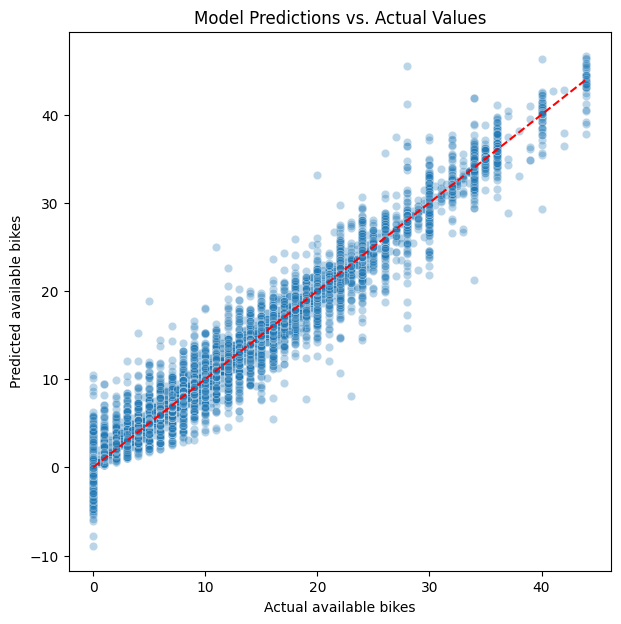

In [118]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual available bikes")
plt.ylabel("Predicted available bikes")
plt.title("Model Predictions vs. Actual Values")
plt.show()

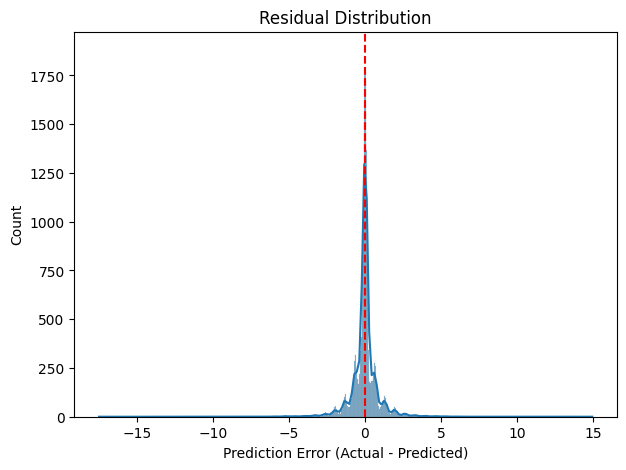

In [119]:

residuals = y_test - predictions

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True)
plt.axvline(0, color='r', linestyle='--')
plt.title("Residual Distribution")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.show()

In [120]:
np.max(abs(residuals))

np.float64(17.478970153457205)

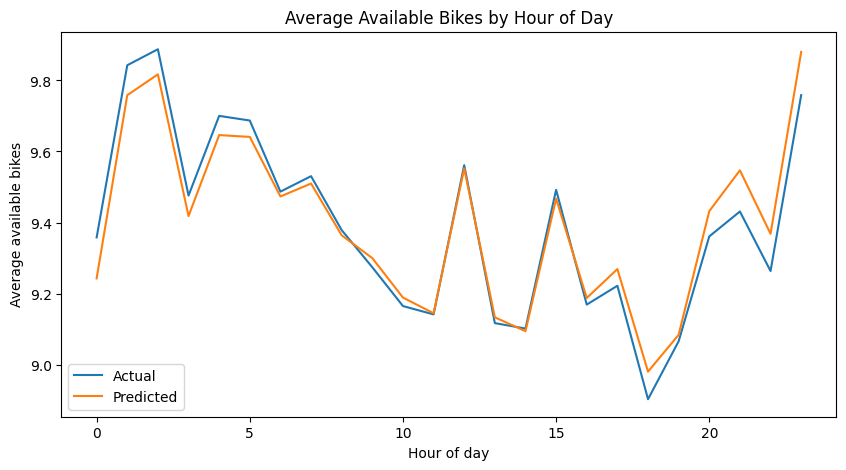

In [121]:
# Add predictions back to test set
X_test_copy = X_sample.copy()
X_test_copy['y_true'] = y_test
X_test_copy['y_pred'] = predictions

# Plot average availability by hour
hourly_avg = X_test_copy.groupby('hour_of_day')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=hourly_avg, x='hour_of_day', y='y_true', label='Actual')
sns.lineplot(data=hourly_avg, x='hour_of_day', y='y_pred', label='Predicted')
plt.title("Average Available Bikes by Hour of Day")
plt.ylabel("Average available bikes")
plt.xlabel("Hour of day")
plt.legend()
plt.show()

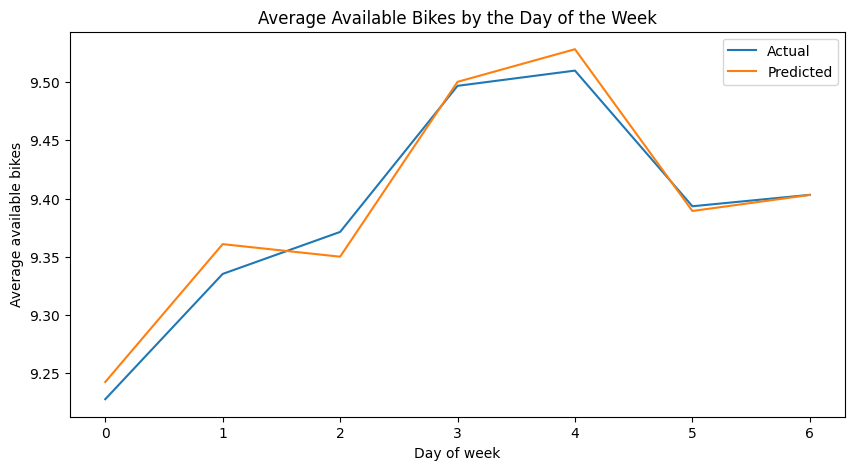

In [122]:
X_test_copy = X_sample.copy()
X_test_copy['y_true'] = y_test
X_test_copy['y_pred'] = predictions

# Plot average availability by hour
daily_avg = X_test_copy.groupby('day_of_week')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=daily_avg, x='day_of_week', y='y_true', label='Actual')
sns.lineplot(data=daily_avg, x='day_of_week', y='y_pred', label='Predicted')
plt.title("Average Available Bikes by the Day of the Week")
plt.ylabel("Average available bikes")
plt.xlabel("Day of week")
plt.legend()
plt.show()

Model performs more poorly with inclusion of weather data (r2 went down from 0.994 to 0.986 and rmse went up from 70 to 96, residuals are also larger), more specifically the rain data (which is imo the most important factor of weather data to look into) -- makes sense since the city bike season is during the warmer months of the year when rainfall is low, apon observing the weather data csv file I noticed most of them were 0's, so adding it to the model's feature inputs only increases the noise of the predictions without addng much value or our predictions. Hence it's safe to say there is no need to include weather data

In [142]:
X_sample_future = pd.DataFrame({'station_id': ['43'], 
    'hour_of_day': [2], 'day_of_week':[2], 'month': [4], 'is_weekend': [0], 'year': [2025],
    'departures': [4], 'arrivals':[0], 'capacity':[20],
    'prev_available':[15], 'prev_departures':[0], 'prev_arrivals': [0], 'rained':[0]
})



bundle = joblib.load(MODEL_PATH)
model = bundle['model']
preprocessor = bundle['preprocessor']

X_transformed = preprocessor.transform(X_sample_future)
pred_future = model.predict(X_transformed)

print("Predicted available bikes:", pred_future)

Predicted available bikes: [9.94029346]
